## Module 5: Analyse, diagnose and improve a model​

In the excercise of this week you will be working with financial data in order to (hopefully) find a portfolio of equities which outperform SP500. The data that you are gonna work with has two main sources: 
* Financial data from the companies extracted from the quarterly company reports (mostly extracted from [macrotrends](https://www.macrotrends.net/) so you can use this website to understand better the data and get insights on the features, for example [this](https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue) is the one corresponding to APPLE)
* Stock prices, mostly extracted from [morningstar](https://indexes.morningstar.com/page/morningstar-indexes-empowering-investor-success?utm_source=google&utm_medium=cpc&utm_campaign=MORNI%3AG%3ASearch%3ABrand%3ACore%3AUK%20MORNI%3ABrand%3ACore%3ABroad&utm_content=engine%3Agoogle%7Ccampaignid%3A18471962329%7Cadid%3A625249340069&utm_term=morningstar%20index&gclid=CjwKCAjws9ipBhB1EiwAccEi1Fu6i20XHVcxFxuSEtJGF0If-kq5-uKnZ3rov3eRkXXFfI5j8QBtBBoCayEQAvD_BwE), which basically tell us how the stock price is evolving so we can use it both as past features and the target to predict).

Before going to the problem that we want to solve, let's comment some of the columns of the dataset:


* `Ticker`: a [short name](https://en.wikipedia.org/wiki/Ticker_symbol) to identify the equity (that you can use to search in macrotrends)
* `date`: the date of the company report (normally we are gonna have 1 every quarter). This is for informative purposes but you can ignore it when modeling.
* `execution date`: the date when we would had executed the algorithm for that equity. We want to execute the algorithm once per quarter to create the portfolio, but the release `date`s of all the different company reports don't always match for the quarter, so we just take a common `execution_date` for all of them.
* `stock_change_div_365`: what is the % change of the stock price (with dividens) in the FOLLOWING year after `execution date`. 
* `sp500_change_365`: what is the % change of the SP500 in the FOLLOWING year after `execution date`.
* `close_0`: what is the price at the moment of `execution date`
* `stock_change__minus_120` what is the % change of the stock price in the last 120 days
* `stock_change__minus_730`: what is the % change of the stock price in the last 730 days

The rest of the features can be divided beteween financial features (the ones coming from the reports) and technical features (coming from the stock price). We leave the technical features here as a reference: 

In [2]:
technical_features = ['close_0', 'close_sp500_0', 'close_365', 'close_sp500_365',
       'close__minus_120', 'close_sp500__minus_120', 'close__minus_365',
       'close_sp500__minus_365', 'close__minus_730', 'close_sp500__minus_730',
       'stock_change_365','stock_change_div_365', 'sp500_change_365', 'stock_change__minus_120',
       'sp500_change__minus_120', 'stock_change__minus_365',
       'sp500_change__minus_365', 'stock_change__minus_730','sp500_change__minus_730',
       'std__minus_365','std__minus_730','std__minus_120']

The problem that we want to solve is basically find a portfolio of `top_n` tickers (initially set to 10) to invest every `execution date` (basically once per quarter) and the goal is to have a better return than `SP500` in the following year. The initial way to model this is to have a binary target which is 1 when `stock_change_div_365` - `sp500_change_365` (the difference between the return of the equity and the SP500 in the following year) is positive or 0 otherwise. So we try to predict the probability of an equity of improving SP500 in the following year, we take the `top_n` equities and compute their final return.

In [51]:
import pandas as pd
import re
import numpy as np
import lightgbm as lgb
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip,geom_bar,scale_x_discrete, geom_point, theme,element_text
import matplotlib.pyplot as plt
import logging
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import SimpleImputer


In [4]:
# number of trees in lightgbm
n_trees = 40
minimum_number_of_tickers = 1500
# Number of the quarters in the past to train
n_train_quarters = 36
# number of tickers to make the portfolio
top_n = 10

In [5]:
data_set = pd.read_feather("../../data/financials_against_return.feather")


Remove these quarters which have les than `minimum_number_of_tickers` tickers:

In [6]:
df_quarter_lengths = data_set.groupby(["execution_date"]).size().reset_index().rename(columns = {0:"count"})
data_set = pd.merge(data_set, df_quarter_lengths, on = ["execution_date"])
data_set = data_set[data_set["count"]>=minimum_number_of_tickers]

In [7]:
data_set.shape

(170483, 145)

Create the target:

In [8]:
data_set["diff_ch_sp500"] = data_set["stock_change_div_365"] - data_set["sp500_change_365"]

data_set.loc[data_set["diff_ch_sp500"]>0,"target"] = 1
data_set.loc[data_set["diff_ch_sp500"]<0,"target"] = 0

data_set["target"].value_counts()

target
0.0    82437
1.0    73829
Name: count, dtype: int64

This function computes the main metric that we want to optimize: given a prediction where we have probabilities for each equity, we sort the equities in descending order of probability, we pick the `top_n` ones, and we we weight the returned `diff_ch_sp500` by the probability:

In [9]:
def get_weighted_performance_of_stocks(df,metric):
    df["norm_prob"] = 1/len(df)
    return np.sum(df["norm_prob"]*df[metric])

def get_top_tickers_per_prob(preds):
    if len(preds) == len(train_set):
        data_set = train_set.copy()
    elif len(preds) == len(test_set):
        data_set = test_set.copy()
    else:
        assert ("Not matching train/test")
    data_set["prob"] = preds
    data_set = data_set.sort_values(["prob"], ascending = False)
    data_set = data_set.head(top_n)
    return data_set

# main metric to evaluate: average diff_ch_sp500 of the top_n stocks
def top_wt_performance(preds, train_data):
    top_dataset = get_top_tickers_per_prob(preds)
    return "weighted-return", get_weighted_performance_of_stocks(top_dataset,"diff_ch_sp500"), True

We have created for you a function to make the `train` and `test` split based on a `execution_date`:

In [10]:
def split_train_test_by_period(data_set, test_execution_date,include_nulls_in_test = False):
    # we train with everything happening at least one year before the test execution date
    train_set = data_set.loc[data_set["execution_date"] <= pd.to_datetime(test_execution_date) - pd.Timedelta(350, unit = "day")]
    # remove those rows where the target is null
    train_set = train_set[~pd.isna(train_set["diff_ch_sp500"])]
    execution_dates = train_set.sort_values("execution_date")["execution_date"].unique()
    # Pick only the last n_train_quarters
    if n_train_quarters!=None:
        train_set = train_set[train_set["execution_date"].isin(execution_dates[-n_train_quarters:])]
        
    # the test set are the rows happening in the execution date with the concrete frequency
    test_set = data_set.loc[(data_set["execution_date"] == test_execution_date)]
    if not include_nulls_in_test:
        test_set = test_set[~pd.isna(test_set["diff_ch_sp500"])]
    test_set = test_set.sort_values('date', ascending = False).drop_duplicates('Ticker', keep = 'first')
    
    return train_set, test_set

Ensure that we don't include features which are irrelevant or related to the target:

In [11]:
def get_columns_to_remove():
    columns_to_remove = [
                         "date",
                         "improve_sp500",
                         "Ticker",
                         "freq",
                         "set",
                         "close_sp500_365",
                         "close_365",
                         "stock_change_365",
                         "sp500_change_365",
                         "stock_change_div_365",
                         "stock_change_730",
                         "sp500_change_365",
                         "stock_change_div_730",
                         "diff_ch_sp500",
                         "diff_ch_avg_500",
                         "execution_date","target","index","quarter","std_730","count"]
        
    return columns_to_remove

This is the main modeling function, it receives a train test and a test set and trains a `lightgbm` in classification mode. We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters:

In [12]:
import warnings
warnings.filterwarnings('ignore')


def train_model(train_set,test_set,n_estimators = 300):

    columns_to_remove = get_columns_to_remove()
    
    X_train = train_set.drop(columns = columns_to_remove, errors = "ignore")
    X_test = test_set.drop(columns = columns_to_remove, errors = "ignore")
    
    
    y_train = train_set["target"]
    y_test = test_set["target"]

    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    eval_result = {}
    
 
    objective = 'binary'
    metric = 'binary_logloss' 
    params = {
             "random_state":1, 
             "verbosity": -1,
             "n_jobs":10, 
             "n_estimators":n_estimators,
             "objective": objective,
             "metric": metric}
    
    model = lgb.train(params = params,train_set = lgb_train,
                      valid_sets = [lgb_test,lgb_train],
                      feval = [top_wt_performance],
                      callbacks = [lgb.record_evaluation(eval_result = eval_result)])
    return model,eval_result,X_train,X_test


 
            

This is the function which receives an `execution_date` and splits the dataset between train and test, trains the models and evaluates the model in test. It returns a dictionary with the different evaluation metrics in train and test:

In [61]:
def run_model_for_execution_date(data_set,execution_date,all_results,all_predicted_tickers_list,all_models,n_estimators,include_nulls_in_test = False):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(data_set,execution_date,include_nulls_in_test = include_nulls_in_test)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None
        X_train = None
        X_test = None
        
        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, X_train, X_test = train_model(train_set,
                                                              test_set,
                                                              n_estimators = n_estimators)
            
            test_set['prob'] = model.predict(X_test)
            predicted_tickers = test_set.sort_values('prob', ascending = False)
            predicted_tickers["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_tickers_list.append(predicted_tickers)
        return all_results,all_predicted_tickers_list,all_models,model,X_train,X_test


execution_dates = np.sort( data_set['execution_date'].unique() )


This is the main training loop: it goes through each different `execution_date` and calls `run_model_for_execution_date`. All the results are stored in `all_results` and the predictions in `all_predicted_tickers_list`.

In [71]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(data_set,execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30T00:00:00.000000000
2013-12-30T00:00:00.000000000
2014-03-31T00:00:00.000000000
2014-06-30T00:00:00.000000000
2014-09-30T00:00:00.000000000
2014-12-30T00:00:00.000000000
2015-03-31T00:00:00.000000000
2015-06-30T00:00:00.000000000
2015-09-30T00:00:00.000000000
2015-12-30T00:00:00.000000000
2016-03-31T00:00:00.000000000
2016-06-30

In [15]:
def parse_results_into_df(set_):
    df = pd.DataFrame()
    for date in all_results:
        df_tmp = pd.DataFrame(all_results[(date)][set_])
        df_tmp["n_trees"] = list(range(len(df_tmp)))
        df_tmp["execution_date"] = date
        df= pd.concat([df,df_tmp])
    
    df["execution_date"] = df["execution_date"].astype(str)
    
    return df

In [72]:
test_results = parse_results_into_df("valid_0")
train_results = parse_results_into_df("training")

In [73]:
test_results_final_tree = test_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree = train_results.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


And this are the results:

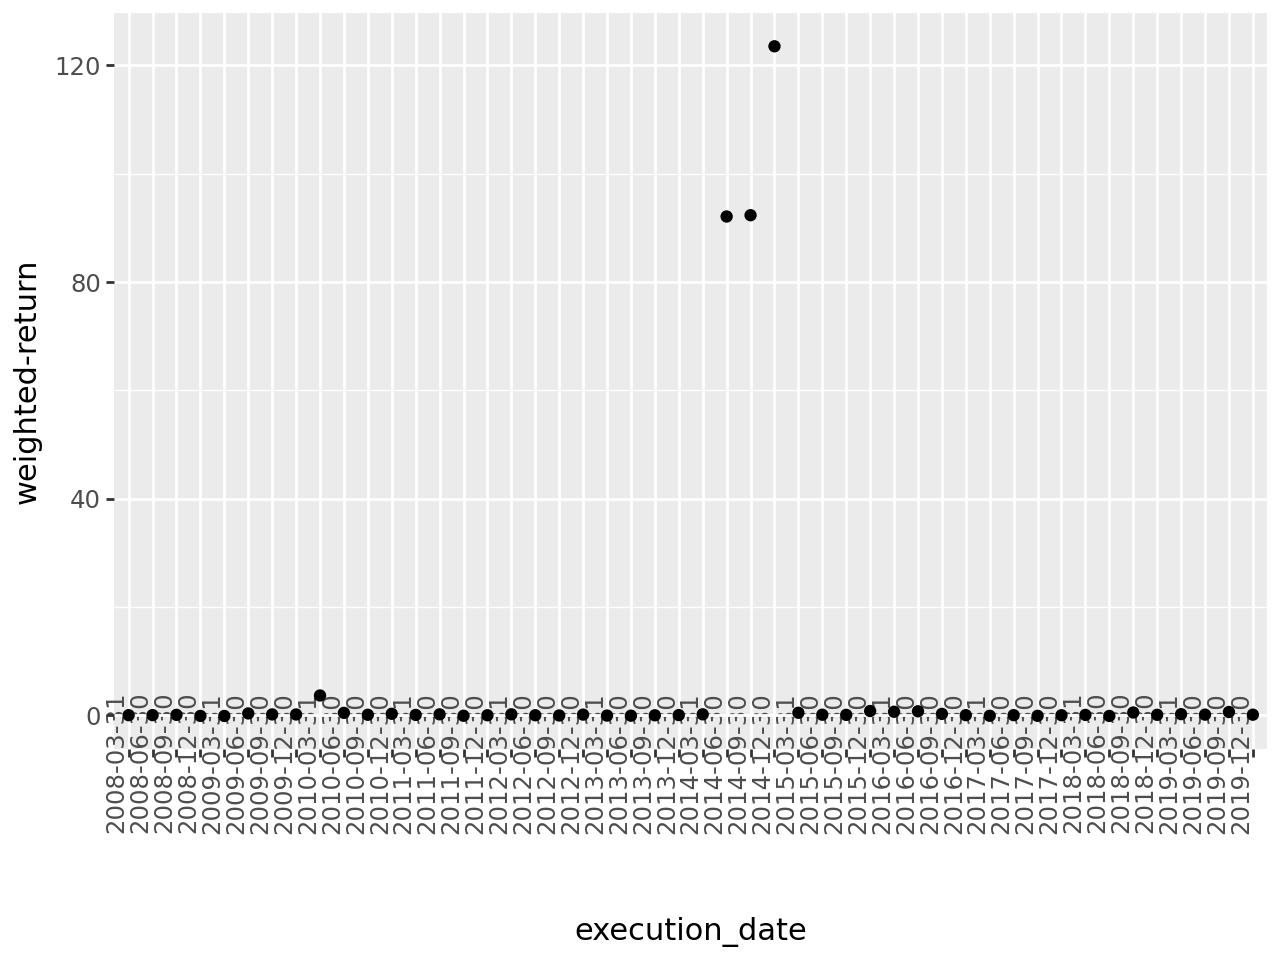

In [74]:
ggplot(test_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))



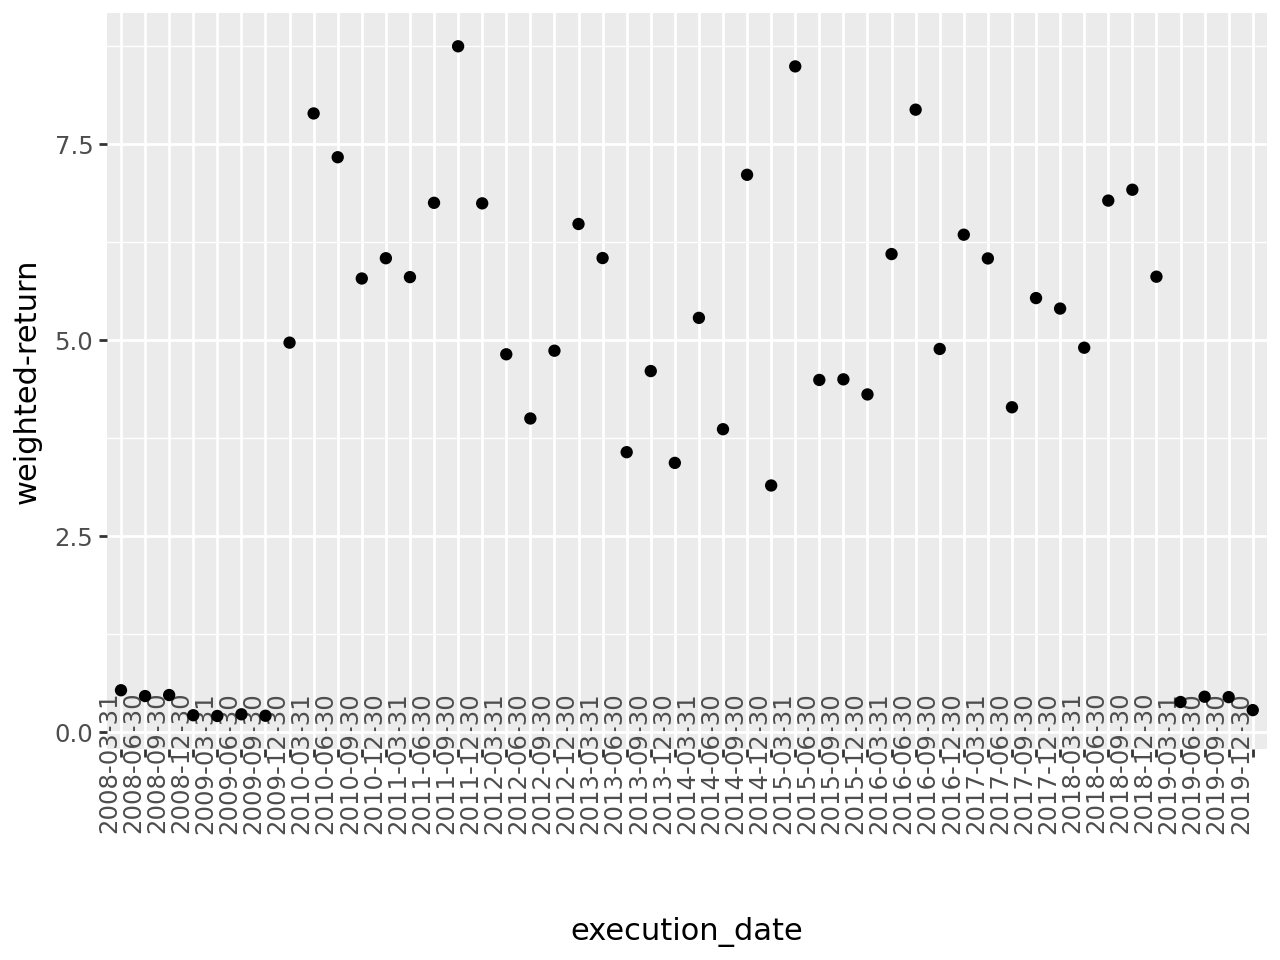

In [75]:
ggplot(train_results_final_tree) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))


We have trained the first models for all the periods for you, but there are a lot of things which may be wrong or can be improved. Some ideas where you can start:
* Try to see if there is any kind of data leakage or suspicious features
* If the training part is very slow, try to see how you can modify it to execute faster tests
* Try to understand if the algorithm is learning correctly
* We are using a very high level metric to evaluate the algorithm so you maybe need to use some more low level ones
* Try to see if there is overfitting
* Try to see if there is a lot of noise between different trainings
* To simplify, why if you only keep the first tickers in terms of Market Cap?
* Change the number of quarters to train in the past

This function can be useful to compute the feature importance:

In [103]:
def draw_feature_importance(model,top = 15):
    fi = model.feature_importance()
    fn = model.feature_name()
    feature_importance = pd.DataFrame([{"feature":fn[i],"imp":fi[i]} for i in range(len(fi))])
    feature_importance = feature_importance.sort_values("imp",ascending = False).head(top)
    feature_importance = feature_importance.sort_values("imp",ascending = True)
    plot = ggplot(feature_importance,aes(x = "feature",y  = "imp")) + geom_col(fill = "lightblue") + coord_flip() +  scale_x_discrete(limits = feature_importance["feature"])
    return plot, feature_importance


In [21]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt

# EXECUTIVE SUMMARY
* I have worked on solving the missing values problem having an aporoach at the beggining which I found to be incorrect( imputing with other tickers as reference) and later using only a subset of tickers which had less NaNs
* getting a reduced data set taking only into account tickers with more data(less NaNs) led to better results
* reducing the number of features taking only the more important ones led to better results (similar using for feature importance Guillermo's proposed function  or SHAP )

# DATA


In [22]:
data_set.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170483 entries, 0 to 170482
Columns: 146 entries, Ticker to target
dtypes: datetime64[ns](2), float64(142), int64(1), object(1)
memory usage: 189.9+ MB


In [23]:
data_set.columns

Index(['Ticker', 'date', 'AssetTurnover', 'CashFlowFromFinancialActivities',
       'CashFlowFromInvestingActivities', 'CashFlowFromOperatingActivities',
       'CashOnHand', 'ChangeInAccountsPayable', 'ChangeInAccountsReceivable',
       'ChangeInAssetsLiabilities',
       ...
       'Revenue_change_2_years', 'NetCashFlow_change_1_years',
       'NetCashFlow_change_2_years', 'CurrentRatio_change_1_years',
       'CurrentRatio_change_2_years', 'Market_cap__minus_365',
       'Market_cap__minus_730', 'diff_ch_sp500', 'count', 'target'],
      dtype='object', length=146)

# Notes from the ipynb:
* `lightgbm` in classification mode. `We don't recommend to change the main algorithm for this excercise but we suggest to play with its hyperparameters`

# Missing Values

Theres a lot of missing values which I need to fullfill if I want to do things like trainin a linear model to look at feature importance

In [24]:
def distribution_with_nans(feature, database):
    '''Count Nans'''
    value_counts = database[feature].value_counts(dropna=False)
    nan_count = database[feature].isnull().sum()
    
   
    top_values = value_counts.head(5)
    top_values['NaN'] = nan_count
    
    return top_values




In [25]:
data_set.head

<bound method NDFrame.head of        Ticker       date  AssetTurnover  CashFlowFromFinancialActivities  \
0           A 2005-01-31         0.1695                           81.000   
1        NDSN 2005-01-31         0.2248                           -3.366   
2        HURC 2005-01-31         0.3782                            0.483   
3         NRT 2005-01-31         1.0517                              NaN   
4         HRL 2005-01-31         0.4880                          -12.075   
...       ...        ...            ...                              ...   
170478   SMSI 2020-12-31         0.1703                            0.010   
170479   COOP 2020-12-31            NaN                         1277.000   
170480     AC 2020-12-31         0.0081                           -3.262   
170481   CRON 2020-12-31         0.0089                           -1.276   
170482   MTEX 2020-12-31         0.5998                           -3.060   

        CashFlowFromInvestingActivities  CashFlowFromOper

In [26]:

total_nans = data_set.isnull().sum().sum()
print(f"Total NanNs/nulls in the dataset: {total_nans}")

rows_with_nan = data_set.isnull().any(axis=1).sum()
print(f"Number of rows with at least a NaN: {rows_with_nan}")


Total NanNs/nulls in the dataset: 3347106
Number of rows with at least a NaN: 170483


Now I will take into acount only the rows used for training

In [27]:
columns_to_remove = get_columns_to_remove()

data_set_train = data_set.copy()
data_set_train = data_set_train.drop(columns=columns_to_remove, errors='ignore')

total_nans = data_set_train.isnull().sum().sum()
print(f"Total NaNs/nulls in the dataset: {total_nans}")

rows_with_nan = data_set_train.isnull().any(axis=1).sum()
print(f"Number of rows with at least a NaN: {rows_with_nan}")



Total NaNs/nulls in the dataset: 3188277
Number of rows with at least a NaN: 170483


the amount of Nans stays de same so I will continue wuth these reduced rows

Now I want to check if NaNs are concentrated in some rows or evenly distributed between them

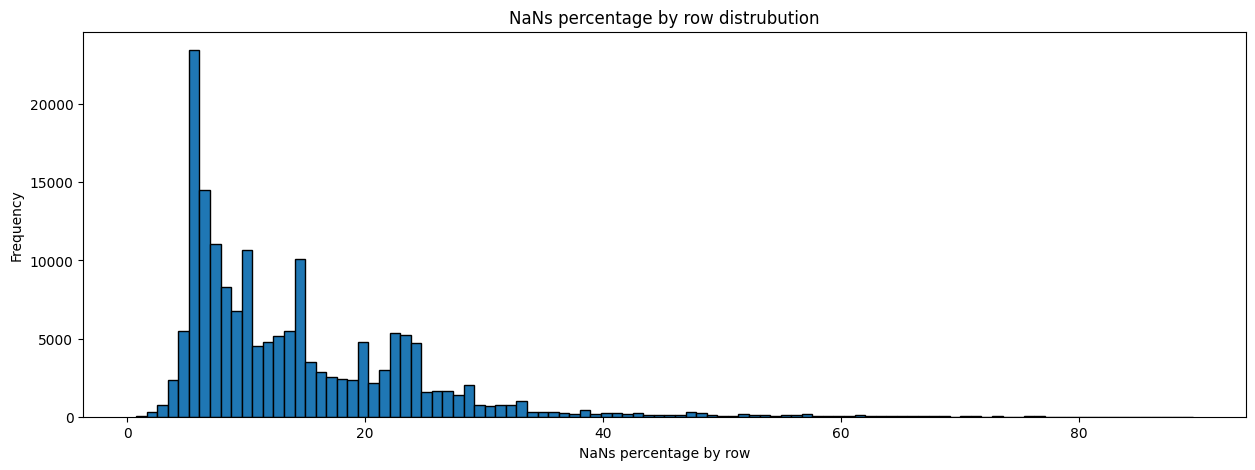

Number of rows over a threshold of NaN percentage:
Percentage > 0%: 170483 rows
Percentage > 25%: 17948 rows
Percentage > 50%: 1626 rows
Percentage > 75%: 96 rows
Percentage > 100%: 0 rows


In [28]:


nan_percentage_per_row = data_set_train.isnull().mean(axis=1) * 100

#NaNs percentage by row
plt.figure(figsize=(15, 5))
nan_percentage_per_row.hist(bins=100, edgecolor='k')
plt.title('NaNs percentage by row distrubution')
plt.xlabel('NaNs percentage by row')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

#threshold analysis
thresholds = [0, 25, 50, 75, 100]
rows_above_threshold = {thresh: (nan_percentage_per_row > thresh).sum() for thresh in thresholds}

print("Number of rows over a threshold of NaN percentage:")
for thresh, count in rows_above_threshold.items():
    print(f"Percentage > {thresh}%: {count} rows")


Bad news

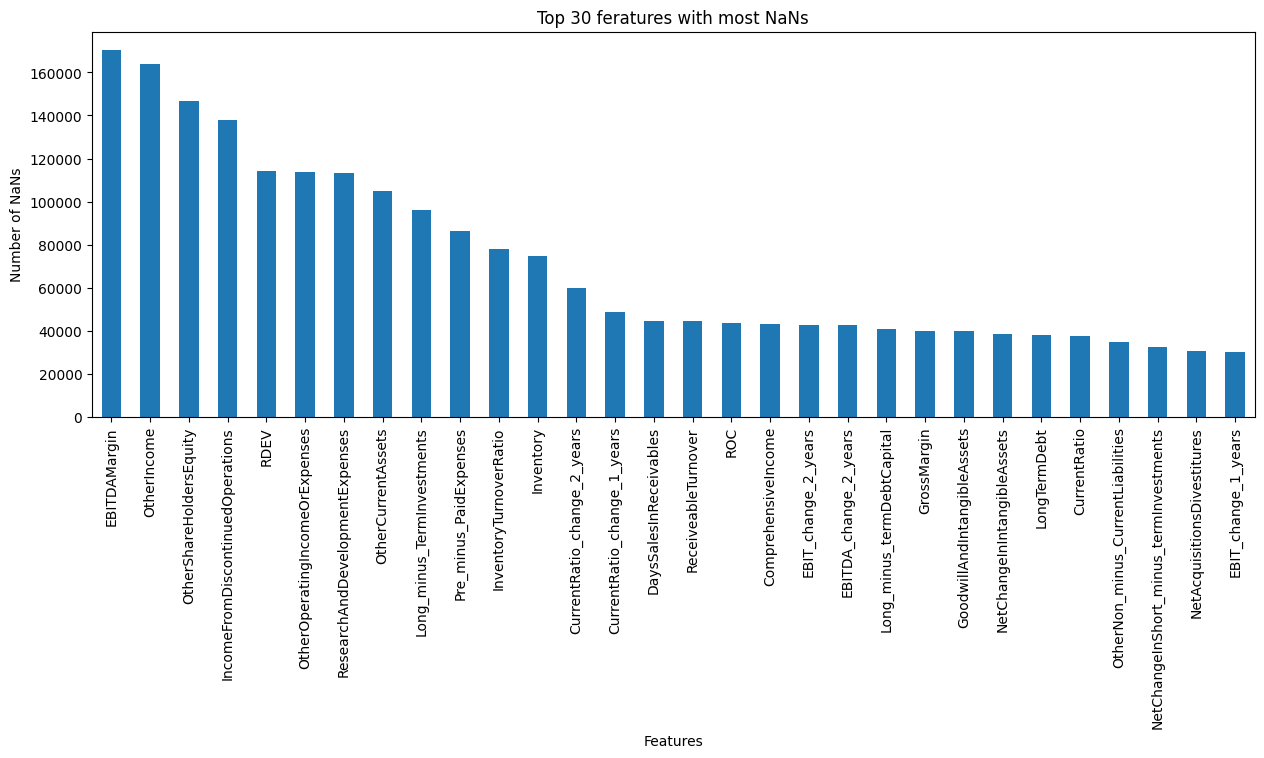

In [29]:

nans_per_feature = data_set_train.isnull().sum()

# NaNs amount by feature
plt.figure(figsize=(15, 5))
nans_per_feature.sort_values(ascending=False).head(30).plot(kind='bar') 
plt.title('Top 30 feratures with most NaNs')
plt.xlabel('Features')
plt.ylabel('Number of NaNs')
plt.show()


In [30]:
print(nans_per_feature.sort_values(ascending=False).head(10))

EBITDAMargin                        170483
OtherIncome                         163774
OtherShareHoldersEquity             146810
IncomeFromDiscontinuedOperations    137802
RDEV                                114041
OtherOperatingIncomeOrExpenses      113701
ResearchAndDevelopmentExpenses      113131
OtherCurrentAssets                  104754
Long_minus_TermInvestments           96060
Pre_minus_PaidExpenses               86462
dtype: int64


In [31]:
def nan_percentage_per_feature(data_set_train):

    '''In order to find out how NaNs are distributed'''

    nan_counts = data_set_train.isnull().sum()
    
    total_rows = len(data_set_train)
    nan_percentage = (nan_counts / total_rows) * 100
    
    return nan_percentage


nan_percentage = nan_percentage_per_feature(data_set_train)
print(nan_percentage.sort_values(ascending=False).head(10))


EBITDAMargin                        100.000000
OtherIncome                          96.064710
OtherShareHoldersEquity              86.114158
IncomeFromDiscontinuedOperations     80.830347
RDEV                                 66.892887
OtherOperatingIncomeOrExpenses       66.693453
ResearchAndDevelopmentExpenses       66.359109
OtherCurrentAssets                   61.445423
Long_minus_TermInvestments           56.345794
Pre_minus_PaidExpenses               50.715907
dtype: float64


In [32]:
 
print(distribution_with_nans('EBITDAMargin', data_set_train))
print("--------------------------------------")
print(distribution_with_nans('OtherIncome', data_set_train))
print("--------------------------------------")
print(distribution_with_nans('OtherShareHoldersEquity', data_set_train))
print("--------------------------------------")
print(distribution_with_nans('IncomeFromDiscontinuedOperations', data_set_train))
print("--------------------------------------")
print(distribution_with_nans('OtherOperatingIncomeOrExpenses', data_set_train))
print("--------------------------------------")
print(distribution_with_nans('ResearchAndDevelopmentExpenses', data_set_train))
print("--------------------------------------")
print(distribution_with_nans('Long_minus_TermInvestments', data_set_train))

EBITDAMargin
NaN    170483
NaN    170483
Name: count, dtype: int64
--------------------------------------
OtherIncome
 NaN     163774
 0.0       5582
-0.01        15
-1.0         12
-0.03        11
 NaN     163774
Name: count, dtype: int64
--------------------------------------
OtherShareHoldersEquity
 NaN       146810
 0.0         2436
-15.458        64
-5.0           61
-0.002         48
 NaN       146810
Name: count, dtype: int64
--------------------------------------
IncomeFromDiscontinuedOperations
 NaN    137802
 0.0      9346
-1.0       307
 1.0       232
-2.0       204
 NaN    137802
Name: count, dtype: int64
--------------------------------------
OtherOperatingIncomeOrExpenses
 NaN    113701
 0.0      1300
-1.0       229
-2.0       172
-3.0       160
 NaN    113701
Name: count, dtype: int64
--------------------------------------
ResearchAndDevelopmentExpenses
 NaN    113131
 0.0      1727
-0.0       371
-0.0       363
-0.0       293
 NaN    113131
Name: count, dtype: int64
---

Now let me check how NaNs appear overtime 

Firt of all I will plot the number of rows by date so we can take something as reference

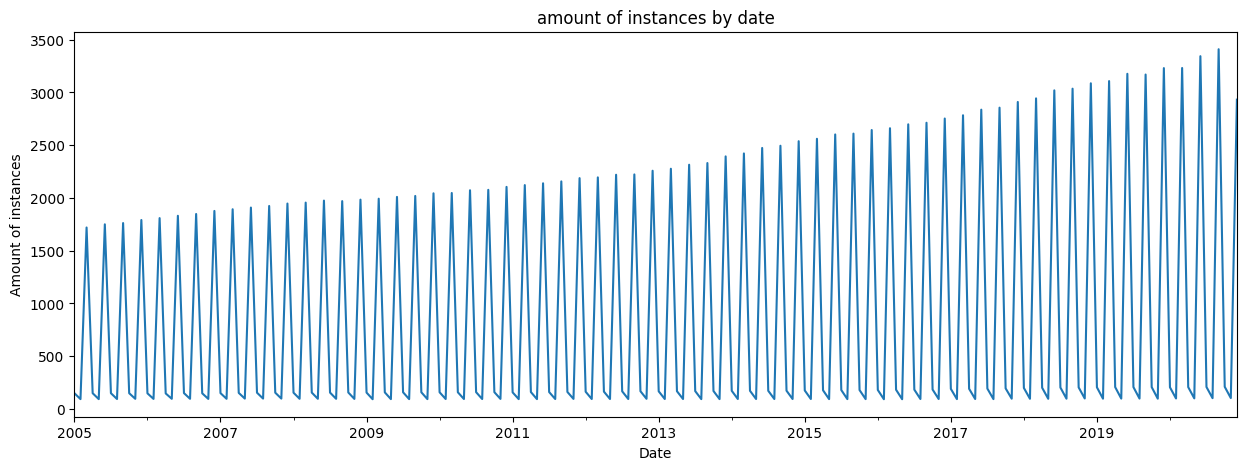

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

if not isinstance(data_set.index, pd.DatetimeIndex):
    data_set['date'] = pd.to_datetime(data_set['date'])
    data_set.set_index('date', inplace=True)

instances_by_date = data_set.groupby('date').size()

#amount of instances by date
plt.figure(figsize=(15, 5))
instances_by_date.plot(kind='line') 
plt.title('amount of instances by date')
plt.xlabel('Date')
plt.ylabel('Amount of instances')
plt.show()


It seem NaNs are evenly distributed in time, I will check by feature now

<Figure size 1500x700 with 0 Axes>

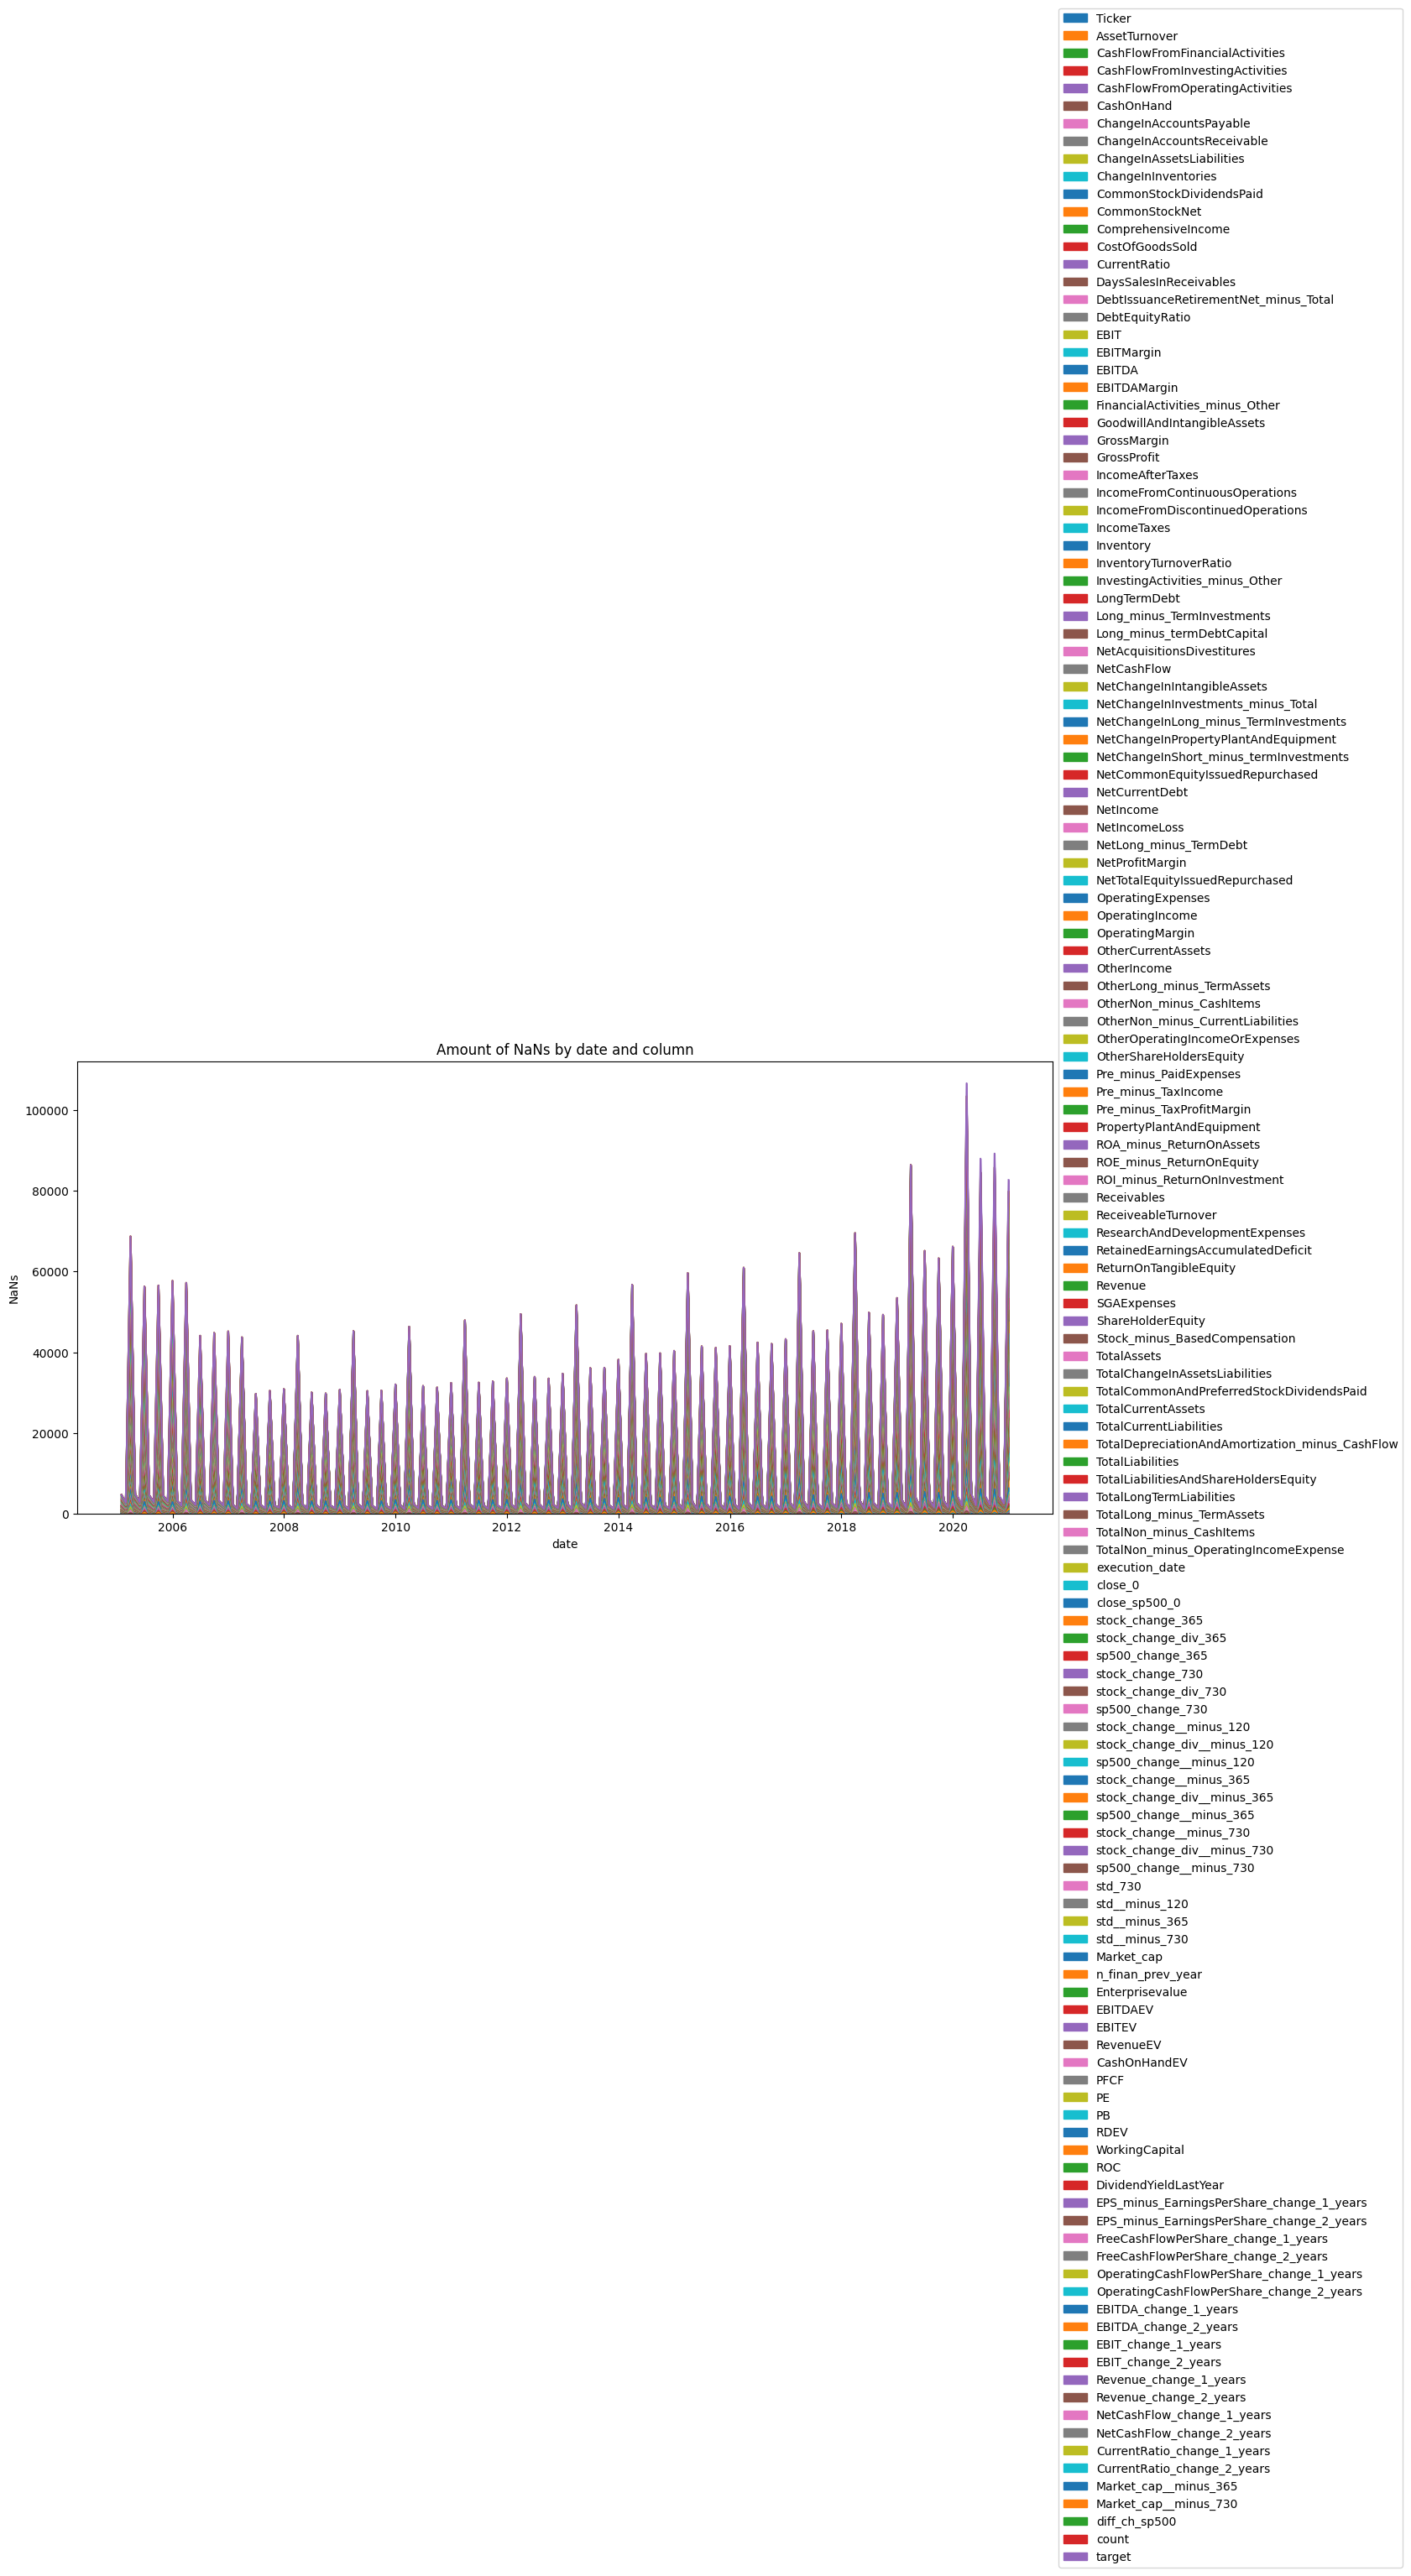

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

if not isinstance(data_set.index, pd.DatetimeIndex):
    data_set['date'] = pd.to_datetime(data_set['date'])
    data_set.set_index('date', inplace=True)


nans_by_date_and_column = data_set.isnull().groupby(data_set.index.date).sum()

# Nans by date and columns
plt.figure(figsize=(15, 7))
nans_by_date_and_column.plot(kind='area', stacked=True, figsize=(15, 7))
plt.title('Amount of NaNs by date and column')
plt.xlabel('date')
plt.ylabel('NaNs')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))  
plt.tight_layout()  
plt.show()


Seems even again, that makes it more difficult to address beacause there is no obvious reason for all that missing values

# Imputing missing values
I want to imputate missing values and avoid data leakage at the same time so Ive thought of calculating the mean/mode (depending on the feature nature) by "batch" of `execution_date`. This way a temporal split would not have values of the mean of train/test values. 

First of all I will check if each execution_date has a big enough number of rows so it does not have much bias

`remark:`After all the analysis y made from this point I came to some conclusions that made me take another path. For this reason I wont comment each code block, I will instead make a recap at the end.

2024-03-03 12:23:12,413 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-03 12:23:12,421 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


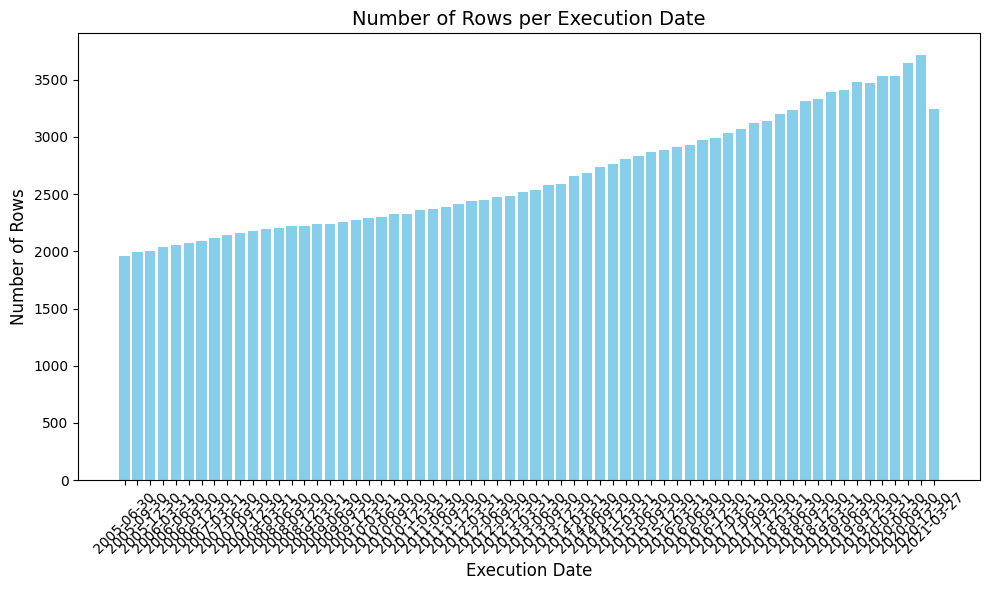

In [35]:

execution_date_counts = data_set['execution_date'].value_counts()
date_counts_df = execution_date_counts.reset_index()
date_counts_df.columns = ['execution_date', 'count']

date_counts_df = date_counts_df.sort_values('execution_date')

plt.figure(figsize=(10, 6))
plt.bar(date_counts_df['execution_date'].astype(str), date_counts_df['count'], color='skyblue')
plt.xlabel('Execution Date', fontsize=12)
plt.ylabel('Number of Rows', fontsize=12)
plt.title('Number of Rows per Execution Date', fontsize=14)
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()


In [36]:
import pandas as pd
from sklearn.impute import SimpleImputer

def impute_missing_values_with_most_frequent(data_set):
    ''' Imputes missing values in the dataset with the most frequent value in each column.'''
    
    data_set = data_set.dropna(axis=1, how='all')
    imputer = SimpleImputer(strategy='most_frequent')
    imputed_data = imputer.fit_transform(data_set)
    imputed_data_set = pd.DataFrame(imputed_data, columns=data_set.columns)
    
    return imputed_data_set


most_frequent_imputed_data_set = impute_missing_values_with_most_frequent(data_set)

In [37]:
most_frequent_imputed_data_set.head

<bound method NDFrame.head of        Ticker AssetTurnover CashFlowFromFinancialActivities  \
0           A        0.1695                            81.0   
1        NDSN        0.2248                          -3.366   
2        HURC        0.3782                           0.483   
3         NRT        1.0517                             0.0   
4         HRL         0.488                         -12.075   
...       ...           ...                             ...   
170478   SMSI        0.1703                            0.01   
170479   COOP          0.01                          1277.0   
170480     AC        0.0081                          -3.262   
170481   CRON        0.0089                          -1.276   
170482   MTEX        0.5998                           -3.06   

       CashFlowFromInvestingActivities CashFlowFromOperatingActivities  \
0                                -57.0                           137.0   
1                               10.663                           

In [38]:

total_nans = most_frequent_imputed_data_set.isnull().sum().sum()
print(f"Total NanNs/nulls in the dataset: {total_nans}")

rows_with_nan = most_frequent_imputed_data_set.isnull().any(axis=1).sum()
print(f"Number of rows with at least a NaN: {rows_with_nan}")

Total NanNs/nulls in the dataset: 0
Number of rows with at least a NaN: 0


In [39]:



def impute_missing_values(data_set):
    '''
    Imputes missing values in numeric columns with the mean and in categorical columns with the most frequent value.
    '''
    
    data_set = data_set.dropna(axis=1, how='all')
    numeric_imputer = SimpleImputer(strategy='mean')
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    numeric_data = data_set.select_dtypes(include=['int64', 'float64'])
    categorical_data = data_set.select_dtypes(exclude=['int64', 'float64'])

    numeric_data.replace([np.inf, -np.inf], np.nan, inplace=True)

    imputed_numeric_data = numeric_imputer.fit_transform(numeric_data)
    imputed_numeric_df = pd.DataFrame(imputed_numeric_data, columns=numeric_data.columns)

    imputed_categorical_data = categorical_imputer.fit_transform(categorical_data)
    imputed_categorical_df = pd.DataFrame(imputed_categorical_data, columns=categorical_data.columns)

    imputed_data = pd.concat([imputed_numeric_df, imputed_categorical_df], axis=1)
    imputed_data = imputed_data[data_set.columns]

    return imputed_data


In [40]:
import pandas as pd


def impute_by_execution_date(data_set):
    grouped = data_set.groupby('execution_date')
    imputed_groups = []

    for name, group in grouped:
        imputed_group = impute_missing_values(group.copy())
        imputed_groups.append(imputed_group)

    imputed_data_set = pd.concat(imputed_groups)
    imputed_data_set.sort_values('execution_date', inplace=True)

    return imputed_data_set


imputed_data_set_by_date = impute_by_execution_date(data_set)


In [41]:
imputed_data_set_by_date.describe()

,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,ChangeInInventories,CommonStockDividendsPaid,...,Market_cap__minus_365,EPS_minus_EarningsPerShare_change_2_years,FreeCashFlowPerShare_change_2_years,OperatingCashFlowPerShare_change_2_years,EBITDA_change_2_years,EBIT_change_2_years,Revenue_change_2_years,NetCashFlow_change_2_years,CurrentRatio_change_2_years,Market_cap__minus_730
count,170483.000000,170483.000000,170483.000000,170483.000000,1.704830e+05,170483.000000,170483.000000,170483.000000,170483.000000,170483.000000,...,1.624880e+05,1.541480e+05,1.541480e+05,1.541480e+05,1.541480e+05,1.541480e+05,1.541480e+05,1.541480e+05,154148.000000,1.541480e+05
mean,0.346694,0.057312,-181.608434,204.509685,3.518923e+03,6.463077,-11.873562,-2.218175,-6.991950,-51.836706,...,8.320609e+03,-1.620007e+14,-1.415250e+13,-3.010782e+12,1.335917e+09,-9.241781e+08,4.263404e+08,1.495379e+13,2.046653,8.111977e+03
min,-2.564500,-117766.000000,-168757.900000,-159785.000000,-3.800000e+01,-154776.000000,-74070.000000,-145919.000000,-164339.000000,-35253.000000,...,6.991500e-02,-6.504579e+18,-5.438894e+17,-2.389229e+17,-1.076349e+12,-9.058803e+13,-3.435967e+07,-5.812157e+17,-0.999794,6.991500e-02
25%,0.054400,-32.792800,-72.280000,0.119100,2.633500e+01,-0.898000,-8.325522,-4.929000,-3.049384,-39.200000,...,2.490839e+02,-4.634146e-01,-4.915423e-01,-2.561018e-01,-3.068822e-01,-5.290720e-01,-1.321549e-02,-1.327819e+00,-0.118717,2.692204e+02
50%,0.161600,-0.781000,-10.500000,16.070000,1.043000e+02,0.000000,0.000000,0.000000,0.000000,-2.356000,...,1.165586e+03,1.589194e-01,1.760026e-01,1.607923e-01,1.454174e-01,9.129287e-02,1.504829e-01,2.702902e-01,0.130533,1.302451e+03
75%,0.278400,9.036950,-0.205000,96.849500,4.242865e+02,0.914790,1.968100,2.469000,0.051000,0.000000,...,5.481409e+03,8.306452e-01,1.091117e+00,7.911356e-01,7.068028e-01,6.970491e-01,4.379381e-01,2.061574e+00,0.343796,6.482844e+03
max,19791.620000,362305.000000,176611.000000,159785.000000,2.613720e+06,77392.600000,54531.000000,145919.000000,230067.000000,11287.000000,...,1.355251e+06,1.614090e+17,1.022894e+17,1.014679e+17,1.377266e+14,1.489490e+12,1.988517e+13,1.701280e+18,44192.500000,1.119621e+06
std,47.999359,2353.507007,2192.485212,1954.868014,4.118268e+04,794.227750,709.487889,1386.177393,1419.475111,249.553841,...,3.119660e+04,2.795018e+16,2.276052e+15,1.170083e+15,3.611739e+11,2.382655e+11,7.974420e+10,4.880753e+15,174.532496,2.871656e+04


In [42]:
imputed_data_set_by_date.head

<bound method NDFrame.head of      Ticker  AssetTurnover  CashFlowFromFinancialActivities  \
0         A         0.1695                           81.000   
1315   HALL         0.2181                            0.013   
1314    SPH         0.5592                           -1.539   
1313   SRCE         0.0125                         -227.878   
1312   LCII         0.5917                           -2.685   
...     ...            ...                              ...   
1085   MNRO         0.1555                          -57.707   
1086    TGA         0.1672                           -5.669   
1087     GD         0.2043                         -803.000   
1077   GDYN         0.1802                            0.021   
3244   MTEX         0.5998                           -3.060   

      CashFlowFromInvestingActivities  CashFlowFromOperatingActivities  \
0                             -57.000                          137.000   
1315                           -6.395                           -

In [43]:
total_nans = imputed_data_set_by_date.isnull().sum().sum()
print(f"Total NanNs/nulls in the dataset: {total_nans}")

rows_with_nan = imputed_data_set_by_date.isnull().any(axis=1).sum()
print(f"Number of rows with at least a NaN: {rows_with_nan}")

Total NanNs/nulls in the dataset: 401946
Number of rows with at least a NaN: 44389


In [44]:

def impute_by_year(data_set):
    data_set['year'] = pd.to_datetime(data_set['execution_date']).dt.year
    grouped = data_set.groupby('year')
    imputed_groups = []
    
    for name, group in grouped:
        imputed_group = impute_missing_values(group.copy())
        imputed_groups.append(imputed_group)
    
    imputed_data_set = pd.concat(imputed_groups)
    imputed_data_set.sort_values('execution_date', inplace=True)
    
    imputed_data_set.drop('year', axis=1, inplace=True)
    

In [45]:
imputed_data_set_by_date_then_year = impute_by_execution_date(imputed_data_set_by_date)

In [46]:
total_nans = imputed_data_set_by_date_then_year.isnull().sum().sum()
print(f"Total NanNs/nulls in the dataset: {total_nans}")

rows_with_nan = imputed_data_set_by_date_then_year.isnull().any(axis=1).sum()
print(f"Number of rows with at least a NaN: {rows_with_nan}")

Total NanNs/nulls in the dataset: 401946
Number of rows with at least a NaN: 44389


In [47]:
data_set['year'] = pd.to_datetime(data_set['execution_date']).dt.year
grouped_by_year = data_set.groupby('year')
columns_all_nan_by_year = {}

for year, group in grouped_by_year:
    columns_all_nan = group.isnull().all()  
    columns_all_nan_by_year[year] = columns_all_nan[columns_all_nan].index.tolist() 

columns_all_nan_by_year

{2005: ['EBITDAMargin',
  'EPS_minus_EarningsPerShare_change_1_years',
  'EPS_minus_EarningsPerShare_change_2_years',
  'FreeCashFlowPerShare_change_1_years',
  'FreeCashFlowPerShare_change_2_years',
  'OperatingCashFlowPerShare_change_1_years',
  'OperatingCashFlowPerShare_change_2_years',
  'EBITDA_change_1_years',
  'EBITDA_change_2_years',
  'EBIT_change_1_years',
  'EBIT_change_2_years',
  'Revenue_change_1_years',
  'Revenue_change_2_years',
  'NetCashFlow_change_1_years',
  'NetCashFlow_change_2_years',
  'CurrentRatio_change_1_years',
  'CurrentRatio_change_2_years',
  'Market_cap__minus_365',
  'Market_cap__minus_730'],
 2006: ['EBITDAMargin',
  'EPS_minus_EarningsPerShare_change_2_years',
  'FreeCashFlowPerShare_change_2_years',
  'OperatingCashFlowPerShare_change_2_years',
  'EBITDA_change_2_years',
  'EBIT_change_2_years',
  'Revenue_change_2_years',
  'NetCashFlow_change_2_years',
  'CurrentRatio_change_2_years',
  'Market_cap__minus_730'],
 2007: ['EBITDAMargin'],
 2008: 

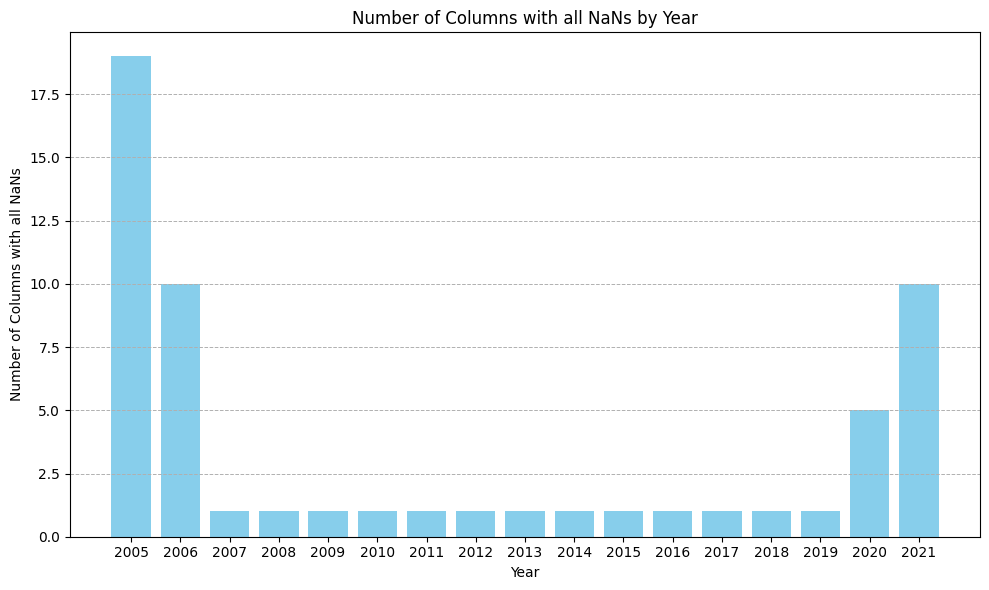

In [48]:

data_set['year'] = pd.to_datetime(data_set['execution_date']).dt.year
grouped_by_year = data_set.groupby('year')
columns_all_nan_by_year = {}

for year, group in grouped_by_year:
    columns_all_nan = group.isnull().all() 
    columns_all_nan_by_year[year] = columns_all_nan[columns_all_nan].index.tolist()


nan_count_by_year = {year: len(columns) for year, columns in columns_all_nan_by_year.items()}

# Plotting the number of columns with all NaNs for each year
plt.figure(figsize=(10, 6))
plt.bar(nan_count_by_year.keys(), nan_count_by_year.values(), color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Columns with all NaNs')
plt.title('Number of Columns with all NaNs by Year')
plt.xticks(list(nan_count_by_year.keys()))  
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout() 
plt.show()


In [49]:

def debug_imputation(data_set):
    print("Columnas originales:", data_set.columns.tolist())

    imputed_data = impute_by_execution_date(data_set)
    print("Columnas después de la imputación:", imputed_data.columns.tolist())

    difference = set(data_set.columns) - set(imputed_data.columns)
    print("Columnas perdidas durante la imputación:", difference)

    return imputed_data

debug_imputation(data_set)

Columnas originales: ['Ticker', 'AssetTurnover', 'CashFlowFromFinancialActivities', 'CashFlowFromInvestingActivities', 'CashFlowFromOperatingActivities', 'CashOnHand', 'ChangeInAccountsPayable', 'ChangeInAccountsReceivable', 'ChangeInAssetsLiabilities', 'ChangeInInventories', 'CommonStockDividendsPaid', 'CommonStockNet', 'ComprehensiveIncome', 'CostOfGoodsSold', 'CurrentRatio', 'DaysSalesInReceivables', 'DebtIssuanceRetirementNet_minus_Total', 'DebtEquityRatio', 'EBIT', 'EBITMargin', 'EBITDA', 'EBITDAMargin', 'FinancialActivities_minus_Other', 'GoodwillAndIntangibleAssets', 'GrossMargin', 'GrossProfit', 'IncomeAfterTaxes', 'IncomeFromContinuousOperations', 'IncomeFromDiscontinuedOperations', 'IncomeTaxes', 'Inventory', 'InventoryTurnoverRatio', 'InvestingActivities_minus_Other', 'LongTermDebt', 'Long_minus_TermInvestments', 'Long_minus_termDebtCapital', 'NetAcquisitionsDivestitures', 'NetCashFlow', 'NetChangeInIntangibleAssets', 'NetChangeInInvestments_minus_Total', 'NetChangeInLong_mi

Columnas después de la imputación: ['Ticker', 'AssetTurnover', 'CashFlowFromFinancialActivities', 'CashFlowFromInvestingActivities', 'CashFlowFromOperatingActivities', 'CashOnHand', 'ChangeInAccountsPayable', 'ChangeInAccountsReceivable', 'ChangeInAssetsLiabilities', 'ChangeInInventories', 'CommonStockDividendsPaid', 'CommonStockNet', 'ComprehensiveIncome', 'CostOfGoodsSold', 'CurrentRatio', 'DaysSalesInReceivables', 'DebtIssuanceRetirementNet_minus_Total', 'DebtEquityRatio', 'EBIT', 'EBITMargin', 'EBITDA', 'FinancialActivities_minus_Other', 'GoodwillAndIntangibleAssets', 'GrossMargin', 'GrossProfit', 'IncomeAfterTaxes', 'IncomeFromContinuousOperations', 'IncomeFromDiscontinuedOperations', 'IncomeTaxes', 'Inventory', 'InventoryTurnoverRatio', 'InvestingActivities_minus_Other', 'LongTermDebt', 'Long_minus_TermInvestments', 'Long_minus_termDebtCapital', 'NetAcquisitionsDivestitures', 'NetCashFlow', 'NetChangeInIntangibleAssets', 'NetChangeInInvestments_minus_Total', 'NetChangeInLong_minu

,Ticker,AssetTurnover,CashFlowFromFinancialActivities,CashFlowFromInvestingActivities,CashFlowFromOperatingActivities,CashOnHand,ChangeInAccountsPayable,ChangeInAccountsReceivable,ChangeInAssetsLiabilities,ChangeInInventories,...,Market_cap__minus_365,EPS_minus_EarningsPerShare_change_2_years,FreeCashFlowPerShare_change_2_years,OperatingCashFlowPerShare_change_2_years,EBITDA_change_2_years,EBIT_change_2_years,Revenue_change_2_years,NetCashFlow_change_2_years,CurrentRatio_change_2_years,Market_cap__minus_730
0,A,0.1695,81.000,-57.000,137.000,2483.000,5.000000,44.000,-5.000,-13.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1315,HALL,0.2181,0.013,-6.395,-0.241,12.758,0.594000,0.848,-2.659,-49.622014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1314,SPH,0.5592,-1.539,-12.944,-22.096,16.902,13.547000,-99.511,5.928,-3.292000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1313,SRCE,0.0125,-227.878,241.424,-4.846,113.207,0.099000,-24.176,-0.109,-49.622014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1312,LCII,0.5917,-2.685,-3.850,9.654,5.543,3.548276,-15.936,0.681,-2.020000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,MNRO,0.1555,-57.707,-32.308,33.521,24.959,0.000000,-1.276,-5.791,3.908000,...,1488.35713,-7.708333e-01,-1.075464e-01,9.463096e-03,-3.035869e-01,-5.966575e-01,-0.077005,4.774684e+00,-0.176645,2943.382220
1086,TGA,0.1672,-5.669,-1.254,14.180,34.510,0.000000,1.873,-0.072,4.948000,...,26.10504,-5.863636e+00,-3.566540e-01,-5.438798e-01,-6.411282e-01,-9.150796e-01,-0.347150,-7.041823e-01,-0.504166,134.301300
1087,GD,0.2043,-803.000,-385.000,2562.000,2824.000,343.000000,707.000,-152.000,636.000000,...,38480.51116,-1.610018e-02,2.221073e-01,2.734158e-01,-2.831103e-02,-5.939918e-02,0.047855,1.951485e+00,0.093509,51548.259600
1077,GDYN,0.1802,0.021,-16.732,2.934,112.745,0.201000,0.985,0.768,0.000000,...,168.97600,-3.772855e+07,4.274057e+10,2.488239e+13,5.110448e+10,-9.058803e+13,0.434469,9.929874e+14,0.266778,11792.376318


# Pause and `remark`


* With the imputation by execution_date there is a problem, Im asuming tickers will behaviour alike. That is a really big assumption to make.
* I didnt thought about adressing the Nans grouping my dataset by `ticker`, what makes a lot of sense as tickers is the thing we are studying.
* For the same reason of the first remark, in case of imputing basing the missing values on past instances of the same ticker could be a less-biased option.
* Maybe I dont need to use all the dataset and I can make use of a reduced cleaner version of it (without reducing it too much).

In [50]:

data_set['NaN_Count'] = data_set.isnull().sum(axis=1)
nan_counts_by_ticker = data_set.groupby('Ticker')['NaN_Count'].sum().sort_values(ascending=False)

print(nan_counts_by_ticker)

Ticker
AB      3762
SSBI    3542
MVO     3037
BCML    2953
HIFS    2753
        ... 
AVO       36
AUVI      34
HRMY      33
ASO       32
XOG       29
Name: NaN_Count, Length: 3845, dtype: int64



In [54]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
df_copy=data_set.copy()
nans_per_feature = data_set.isna().sum()

#getting out features over this threshold
threshold = len(df_copy) * 0.5
features_to_drop = nans_per_feature[nans_per_feature > threshold].index
df_cleaned = df_copy.drop(columns=features_to_drop)

#there is features with values from even two years before in time. Of course these will be Nan for the first years since there
df_cleaned['execution_date'] = pd.to_datetime(df_cleaned['execution_date'])
cutoff_date = df_cleaned['execution_date'].min() + pd.DateOffset(years=2)
df_cleaned = df_cleaned[df_cleaned['execution_date'] > cutoff_date]

#last year has features with values from the following year (one of these used to calculate the target)
max_date = df_cleaned['execution_date'].max()
one_year_before_max = max_date - pd.DateOffset(years=1)
df_cleaned = df_cleaned[df_cleaned['execution_date'] <= one_year_before_max]

Threshold was a personal decision and could be changed

N tickers:  100


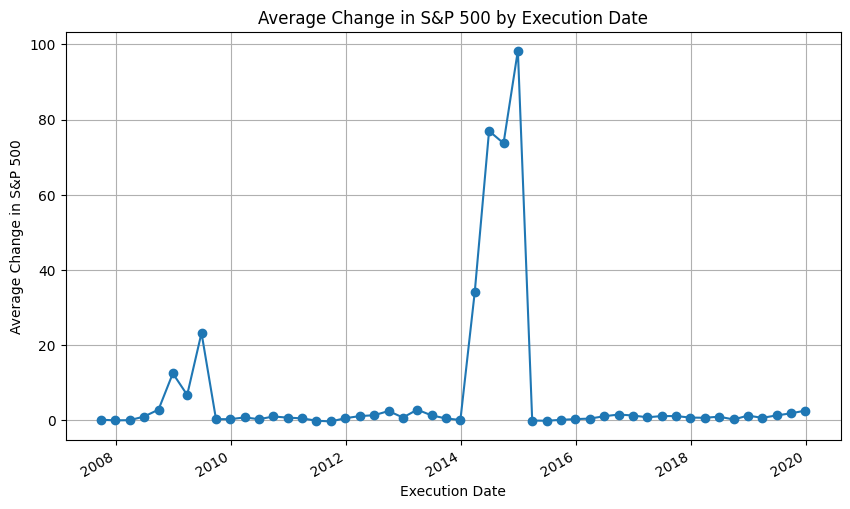

In [55]:

#if for any of these features are missing values, : LOFC
nans_stock_change = df_cleaned['stock_change_div_365'].isna().sum()
nans_sp500_change = df_cleaned['sp500_change_365'].isna().sum()
df_cleaned['stock_change_div_365'] = df_cleaned['stock_change_div_365'].fillna(df_cleaned['stock_change_div_365'].median())
lof = LocalOutlierFactor()
outliers = lof.fit_predict(df_cleaned[['stock_change_div_365']])
top_tickers = df_cleaned.groupby('Ticker')['diff_ch_sp500'].mean().nlargest(100).index
df_cleaned = df_cleaned[df_cleaned['Ticker'].isin(top_tickers)]
distinct_tickers = df_cleaned['Ticker'].nunique()
print("N tickers: ", distinct_tickers)


mean_diff_by_date = df_cleaned.groupby('execution_date')['diff_ch_sp500'].mean()
plt.figure(figsize=(10, 6))
mean_diff_by_date.plot(kind='line', marker='o')
plt.title('Average Change in S&P 500 by Execution Date')
plt.xlabel('Execution Date')
plt.ylabel('Average Change in S&P 500')
plt.grid(True)
plt.show()

We can see some kind of temporal tendency of high change (2009 and 2015) but we dont really know if it is a real tendency or just a coincidence

consecutive nans: std_730                                      337
sp500_change_730                             267
stock_change_div_730                         267
stock_change_730                             267
TotalCommonAndPreferredStockDividendsPaid     17
                                            ... 
close_sp500_0                                  0
close_0                                        0
execution_date                                 0
NetIncomeLoss                                  0
NaN_Count                                      0
Length: 137, dtype: int64


<Figure size 1200x600 with 0 Axes>

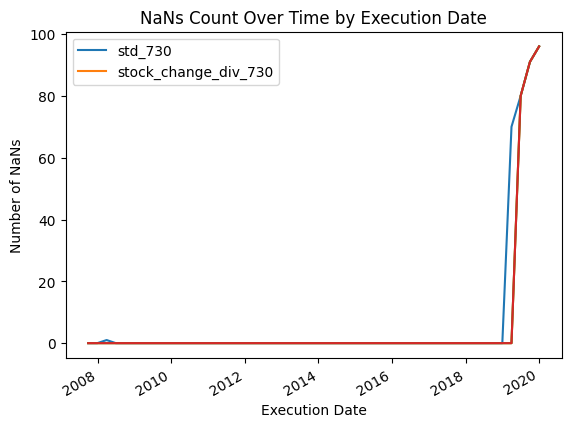

In [56]:
#checking consecutive nans now:
def max_consecutive_nans(series):
    return (series.isna().astype(int).groupby(series.notna().astype(int).cumsum()).sum().max())
max_nans_by_feature = df_cleaned.apply(max_consecutive_nans)
max_nans_by_feature_sorted = max_nans_by_feature.sort_values(ascending=False)

print("consecutive nans:",max_nans_by_feature_sorted)



#graph of distribution of nans of features with consecutives Nans oover time
features_with_consecutive_nans_graph = ['std_730', 'stock_change_div_730']
nans_by_date = df_cleaned.set_index('execution_date')[['std_730', 'sp500_change_730', 'stock_change_730', 'stock_change_div_730']].isna().groupby(level=0).sum()
plt.figure(figsize=(12, 6))
nans_by_date.plot(kind='line')
plt.title('NaNs Count Over Time by Execution Date')
plt.xlabel('Execution Date')
plt.ylabel('Number of NaNs')
plt.legend(['std_730', 'stock_change_div_730'])
plt.show()


In [57]:
#applying ffil()
df_cleaned = df_cleaned.ffill()
max_nans_by_feature = df_cleaned.apply(max_consecutive_nans)
max_nans_by_feature_sorted = max_nans_by_feature.sort_values(ascending=False)
print(max_nans_by_feature_sorted)

#getting 2007 out since all Nans now are in that year and  starting  our analysis from 2008, which is also good starting point
df_cleaned= df_cleaned[df_cleaned['execution_date'] >= pd.Timestamp('2008-01-01')]
nans_rows = df_cleaned[df_cleaned.isna().any(axis=1)]
features_with_nans_and_dates = [(column, row['execution_date']) for index, row in nans_rows.iterrows() for column in nans_rows.columns if pd.isna(row[column])]

Long_minus_termDebtCapital                5
LongTermDebt                              5
ComprehensiveIncome                       2
GoodwillAndIntangibleAssets               1
NetChangeInShort_minus_termInvestments    1
                                         ..
OtherLong_minus_TermAssets                0
OperatingMargin                           0
OperatingIncome                           0
OperatingExpenses                         0
NaN_Count                                 0
Length: 137, dtype: int64


I used forward fill for non consecutive NaNs as I prefer that rather than using other tickers to impute

In [58]:

total_nans = df_cleaned.isna().sum().sum()
print("total nans: ",total_nans)

total nans:  0


### Test

In [77]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

execution_dates = np.sort( df_cleaned['execution_date'].unique() )

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(df_cleaned,execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30T00:00:00.000000000
2013-12-30T00:00:00.000000000
2014-03-31T00:00:00.000000000
2014-06-30T00:00:00.000000000
2014-09-30T00:00:00.000000000
2014-12-30T00:00:00.000000000
2015-03-31T00:00:00.000000000
2015-06-30T00:00:00.000000000
2015-09-30T00:00:00.000000000
2015-12-30T00:00:00.000000000
2016-03-31T00:00:00.000000000
2016-06-30

In [135]:
test_results_1 = parse_results_into_df("valid_0")
train_results_1 = parse_results_into_df("training")
test_results_final_tree_1 = test_results_1.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree_1 = train_results_1.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")


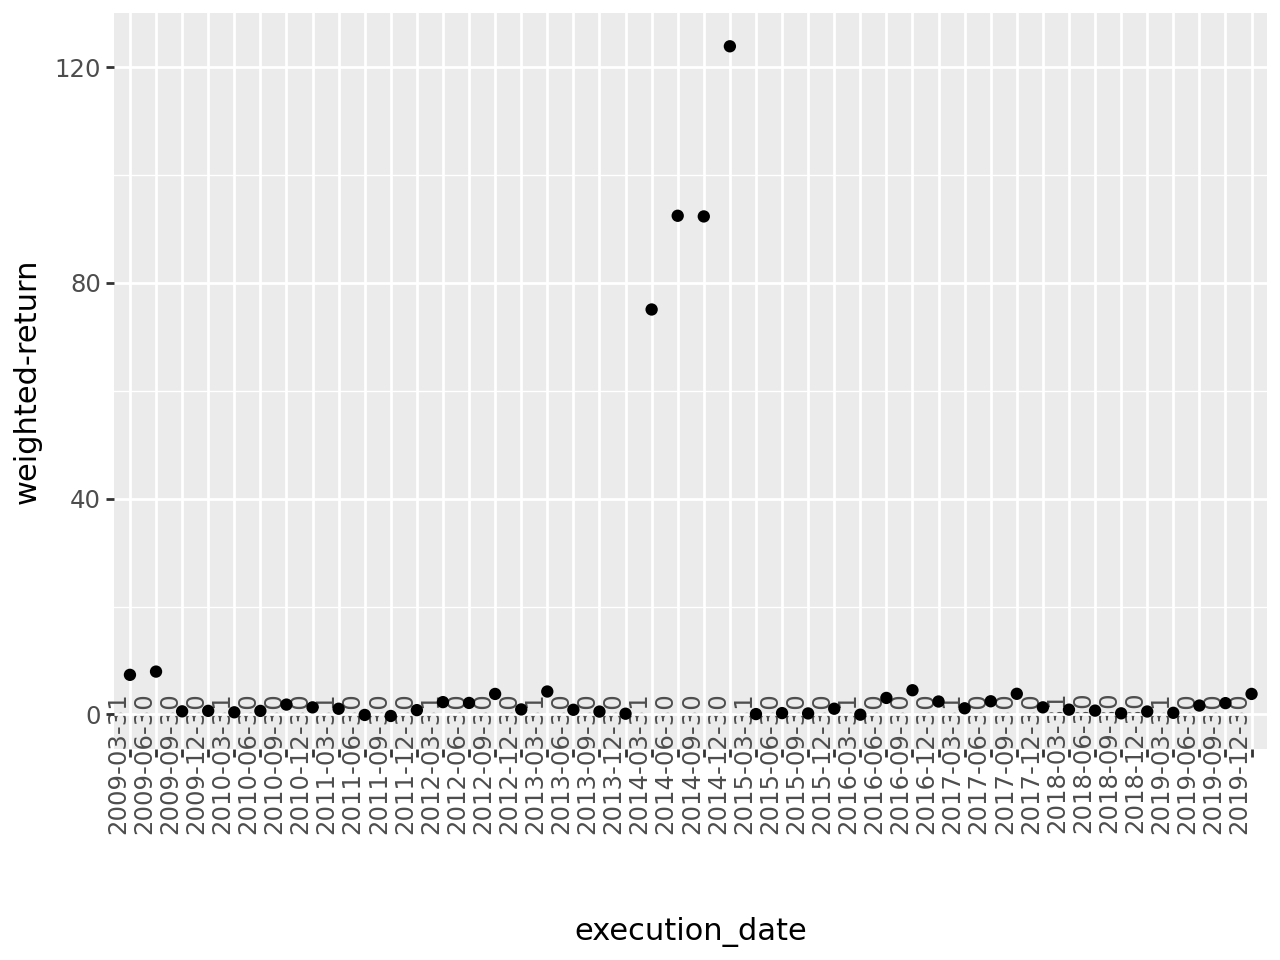

In [136]:
ggplot(test_results_final_tree_1) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

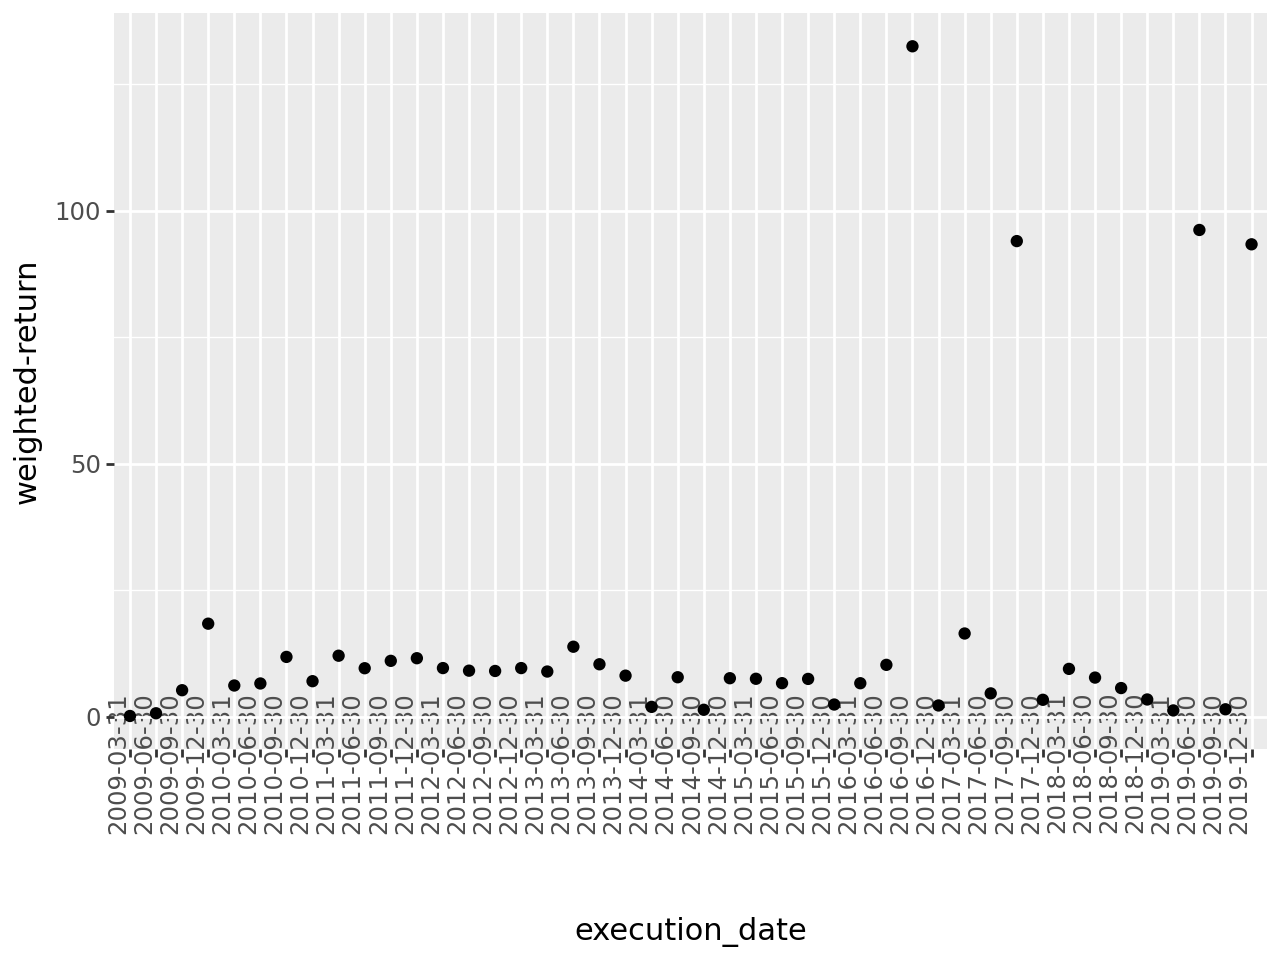

In [92]:

ggplot(train_results_final_tree_1) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Feature importance

* A outstandingly important feature can be a sing of `overfitting`

In [151]:
def print_stats(df):
    mean_logloss = df['binary_logloss'].mean()
    mean_weighted_return = df['weighted-return'].mean()
    mean_top10_weighted_return = df['weighted-return'].nlargest(10).mean()
    
    print(f"Mean Log Loss: {mean_logloss}")
    print(f"Mean Weighted Return: {mean_weighted_return}")
    print(f"Mean of Top 10 Weighted Return: {mean_top10_weighted_return}")

In [167]:
#Results of base

print_stats(test_results)
print("-------------------------------")
print_stats(train_results)

Mean Log Loss: 0.6933356851996422
Mean Weighted Return: 3.5960466851720105
Mean of Top 10 Weighted Return: 122.96654193096686
-------------------------------
Mean Log Loss: 0.6336181186805162
Mean Weighted Return: 2.8895566690412977
Mean of Top 10 Weighted Return: 8.983610045306643


In [168]:
#Results of df_cleaned (no NaNs)

print_stats(test_results_1)
print("-------------------------------")
print_stats(train_results_1)

Mean Log Loss: 0.7562062501889308
Mean Weighted Return: 9.632302973890356
Mean of Top 10 Weighted Return: 124.14343315168647
-------------------------------
Mean Log Loss: 0.348983966511571
Mean Weighted Return: 13.654067274902596
Mean of Top 10 Weighted Return: 143.89111154938638


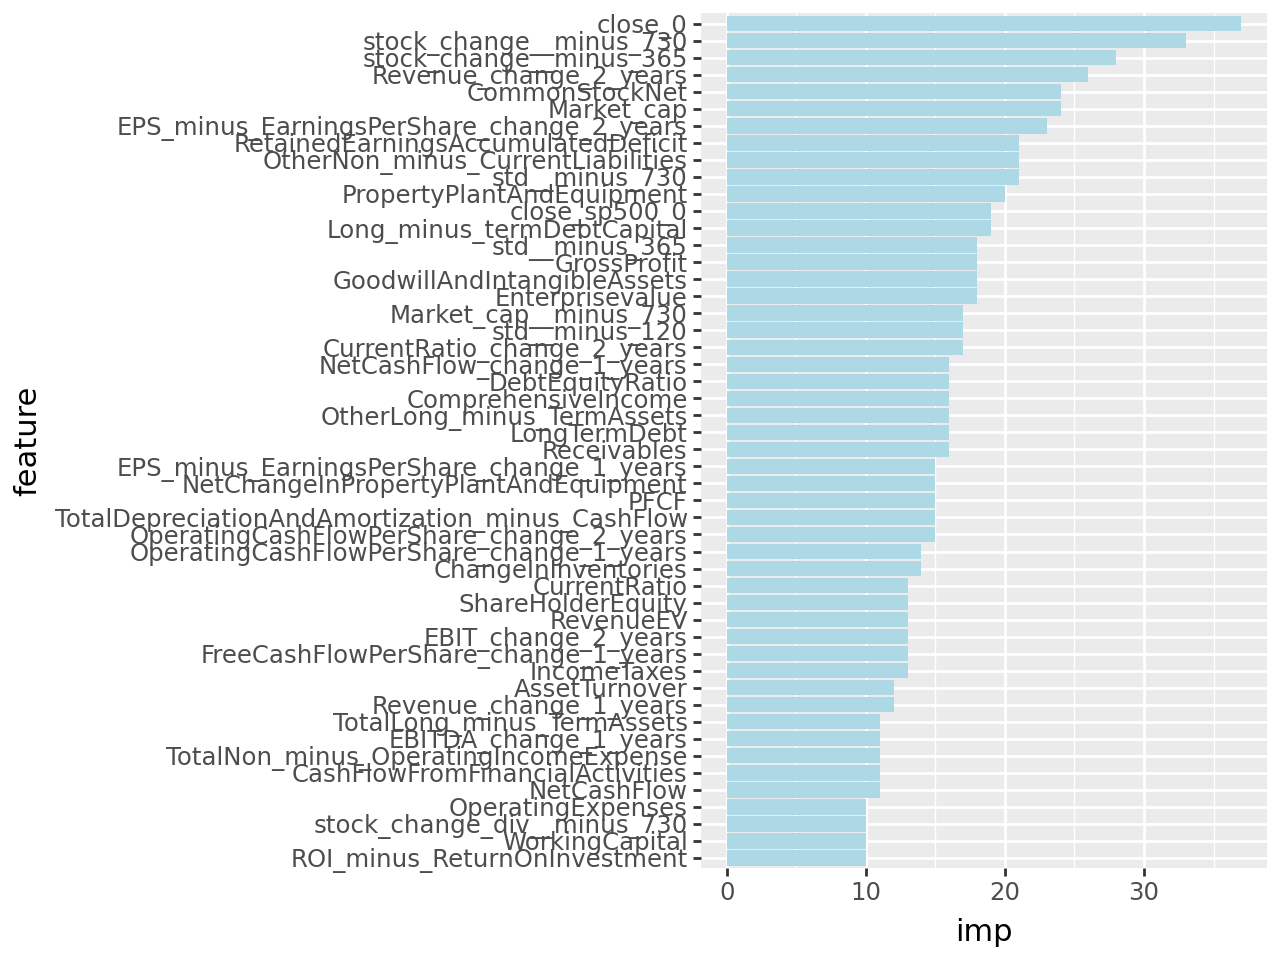

In [109]:
importances_plot, df_importance = draw_feature_importance(model, top=50)
importances_plot

In [130]:
def filter_top_features(df_data, df_features):
    """
    This function filters the dataframe to include only the top features.
    """

    list_features = df_features['feature'].tolist()
 
    if 'execution_date' not in list_features:
        list_features.append('execution_date')
 
    if 'diff_ch_sp500' not in list_features:
        list_features.append('diff_ch_sp500')

    if 'Ticker' not in list_features:
        list_features.append('Ticker')

    if 'target' not in list_features:
        list_features.append('target')
        
    df_cleaned_ft = df_data[list_features]

    return df_cleaned_ft




In [131]:
df_cleaned_ft50 = filter_top_features(df_cleaned, df_importance)

In [121]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

execution_dates = np.sort( df_cleaned['execution_date'].unique() )

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(df_cleaned_ft50,execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000


2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30T00:00:00.000000000
2013-12-30T00:00:00.000000000
2014-03-31T00:00:00.000000000
2014-06-30T00:00:00.000000000
2014-09-30T00:00:00.000000000
2014-12-30T00:00:00.000000000
2015-03-31T00:00:00.000000000
2015-06-30T00:00:00.000000000
2015-09-30T00:00:00.000000000
2015-12-30T00:00:00.000000000
2016-03-31T00:00:00.000000000
2016-06-30T00:00:00.000000000
2016-09-30T00:00:00.000000000
2016-12-30T00:00:00.000000000
2017-03-31T00:00:00.000000000
2017-06-30T00:00:00.000000000
2017-09-30T00:00:00.000000000
2017-12-30

In [139]:
test_results_2 = parse_results_into_df("valid_0")
train_results_2 = parse_results_into_df("training")
test_results_final_tree_2 = test_results_1.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree_2 = train_results_1.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

In [159]:
print(test_results_2)

    binary_logloss  weighted-return  n_trees execution_date
0         1.008419         7.343821        0     2009-03-31
1         1.008419         7.343821        1     2009-03-31
2         1.008419         7.343821        2     2009-03-31
3         1.008419         7.343821        3     2009-03-31
4         1.008419         7.343821        4     2009-03-31
..             ...              ...      ...            ...
35        0.623987         3.873723       35     2019-12-30
36        0.623641         3.873723       36     2019-12-30
37        0.620751         3.873723       37     2019-12-30
38        0.622949         3.873723       38     2019-12-30
39        0.625017         3.807892       39     2019-12-30

[1760 rows x 4 columns]


In [160]:
print_stats(test_results_final_tree_2)
print("-------------------------------")
print_stats(train_results_final_tree_2)

Mean Log Loss: 0.803687230737451
Mean Weighted Return: 10.258477380657228
Mean of Top 10 Weighted Return: 41.54487763061637
-------------------------------
Mean Log Loss: 0.18681284873060786
Mean Weighted Return: 18.749076915779685
Mean of Top 10 Weighted Return: 63.08330644822786


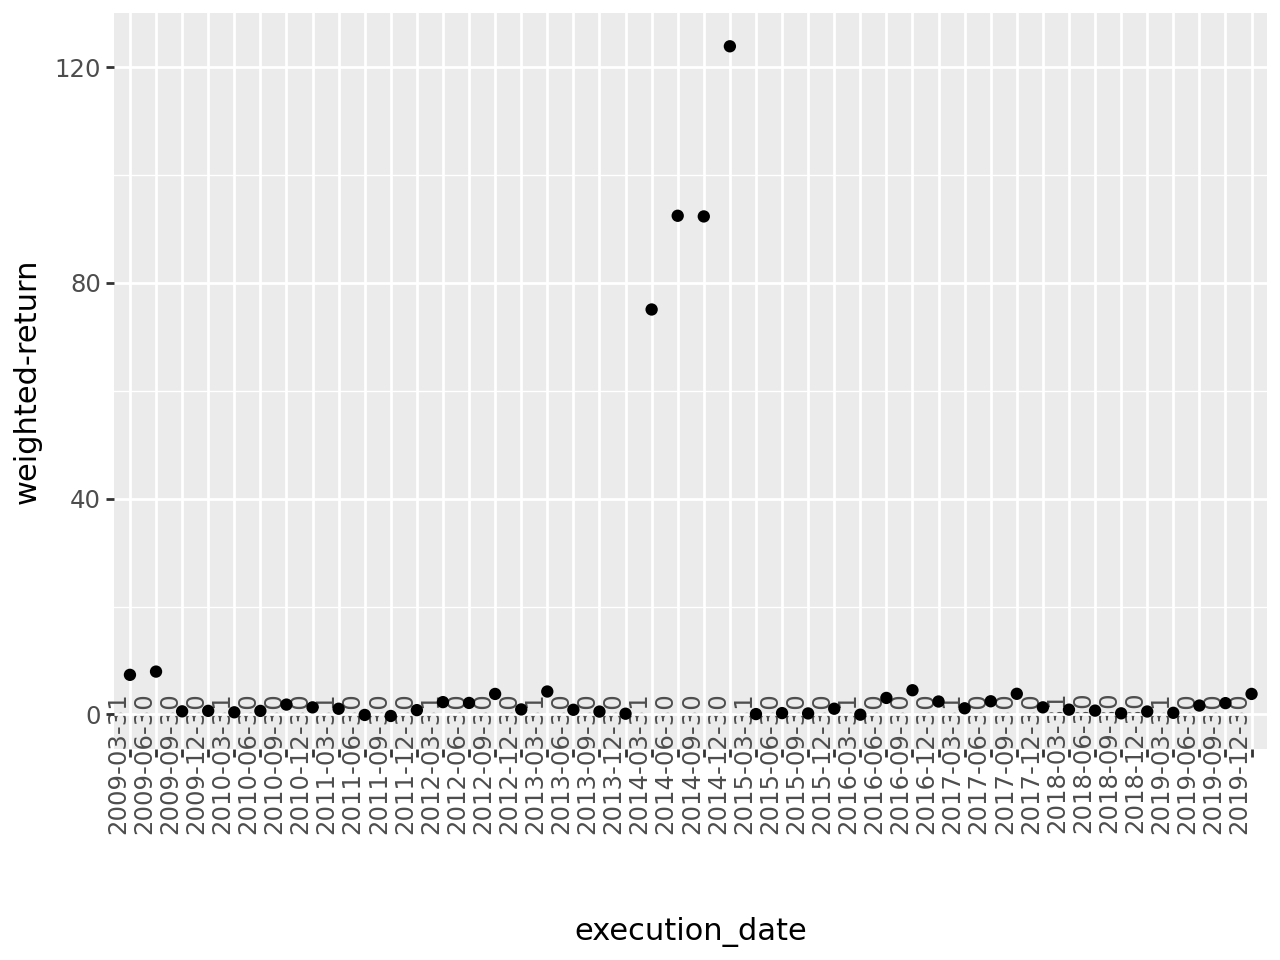

In [140]:
ggplot(test_results_final_tree_2) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

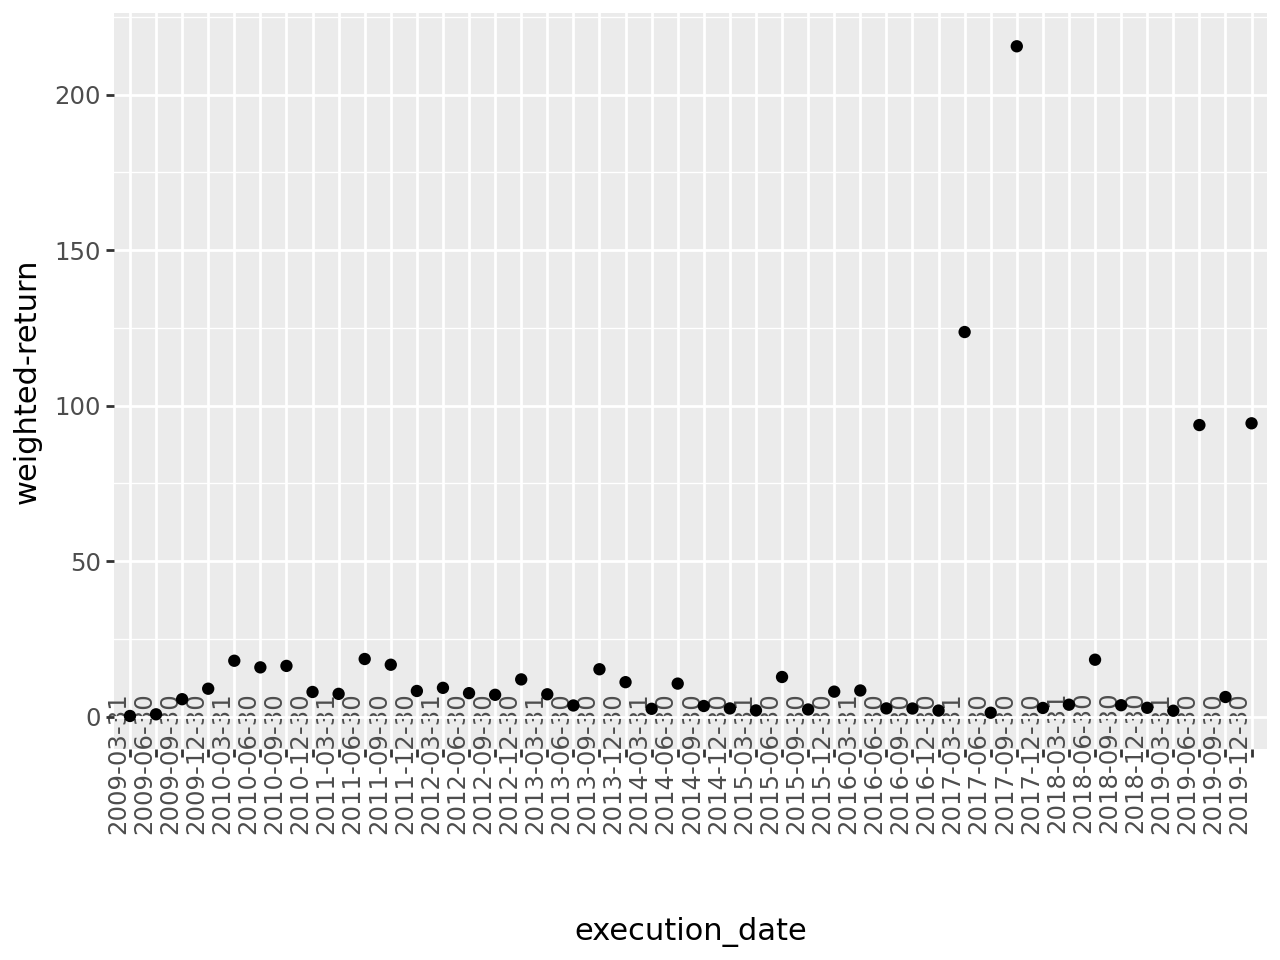

In [141]:

ggplot(train_results_final_tree_2) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

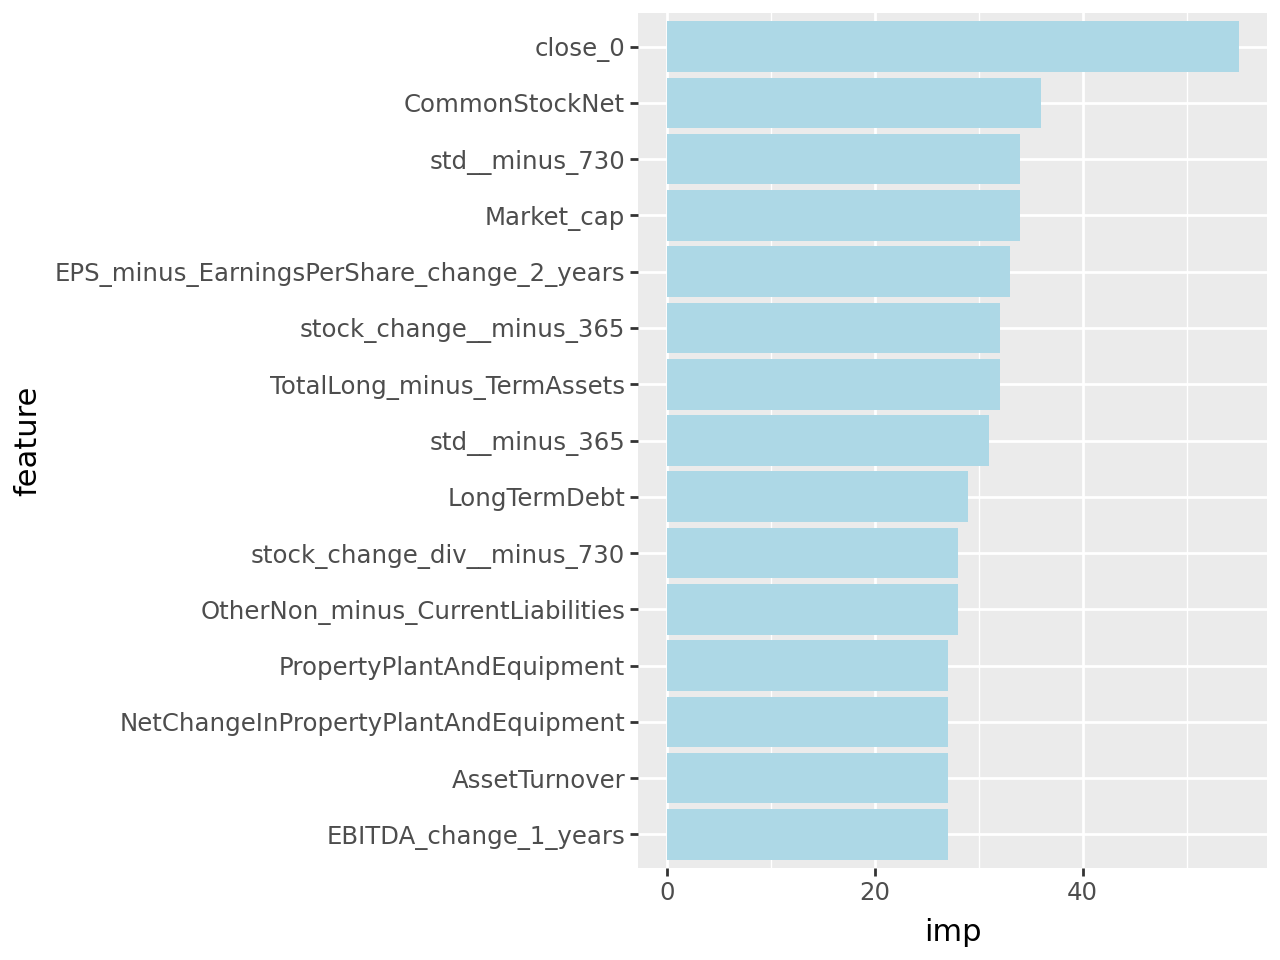

In [142]:
importances_plot, df_importance_15 = draw_feature_importance(model, top=15)
importances_plot

In [143]:
df_cleaned_ft15 = filter_top_features(df_cleaned, df_importance_15)

In [144]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

execution_dates = np.sort( df_cleaned['execution_date'].unique() )

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(df_cleaned_ft15,execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list) 

2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30T00:00:00.000000000
2013-12-30T00:00:00.000000000
2014-03-31T00:00:00.000000000
2014-06-30T00:00:00.000000000
2014-09-30T00:00:00.000000000
2014-12-30T00:00:00.000000000
2015-03-31T00:00:00.000000000
2015-06-30T00:00:00.000000000
2015-09-30T00:00:00.000000000
2015-12-30T00:00:00.000000000
2016-03-31T00:00:00.000000000
2016-06-30

In [145]:
test_results_3 = parse_results_into_df("valid_0")
train_results_3 = parse_results_into_df("training")
test_results_final_tree_3 = test_results_1.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree_3 = train_results_1.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")

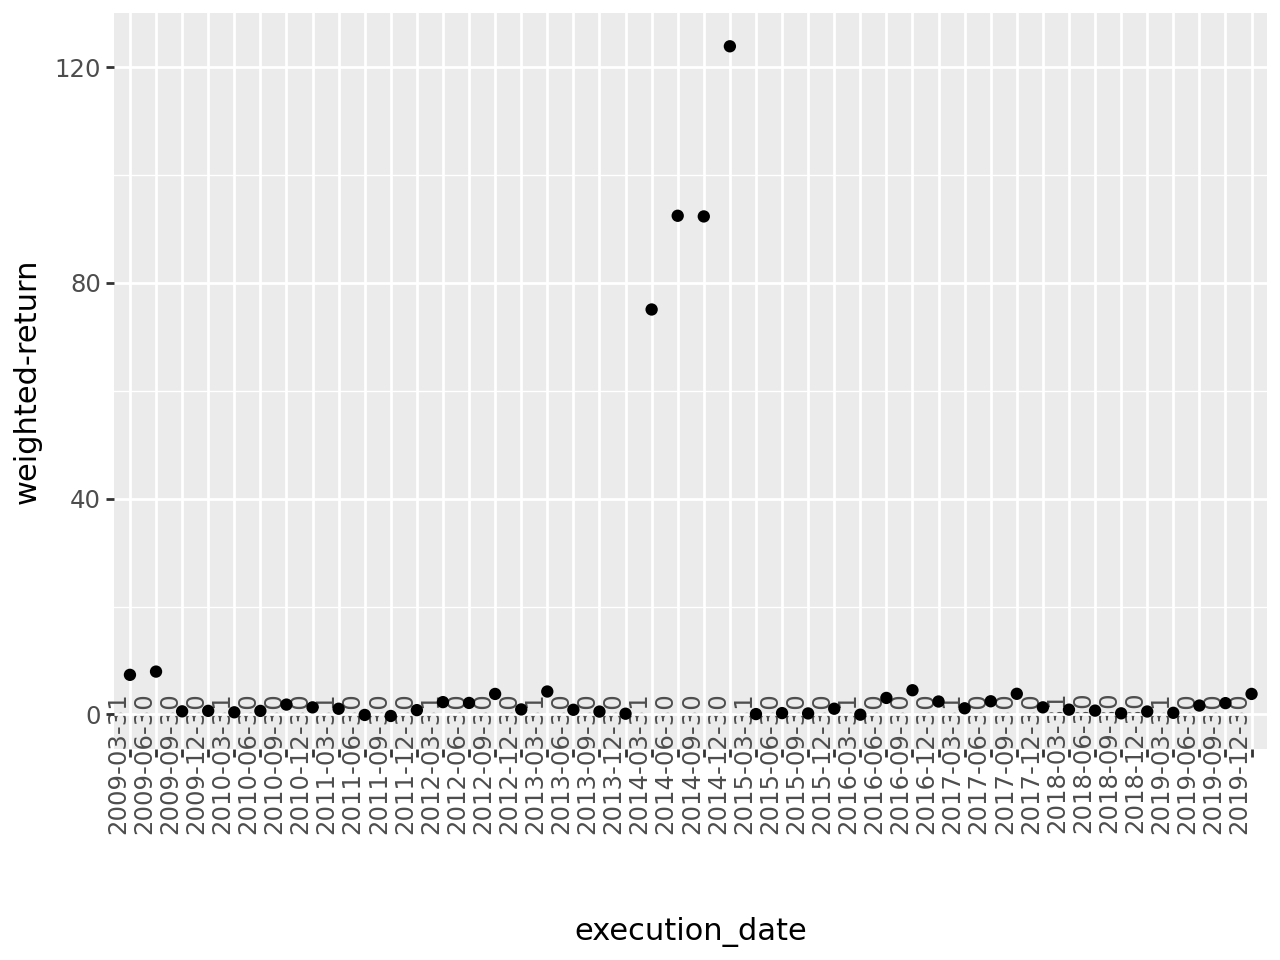

In [146]:
ggplot(test_results_final_tree_3) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

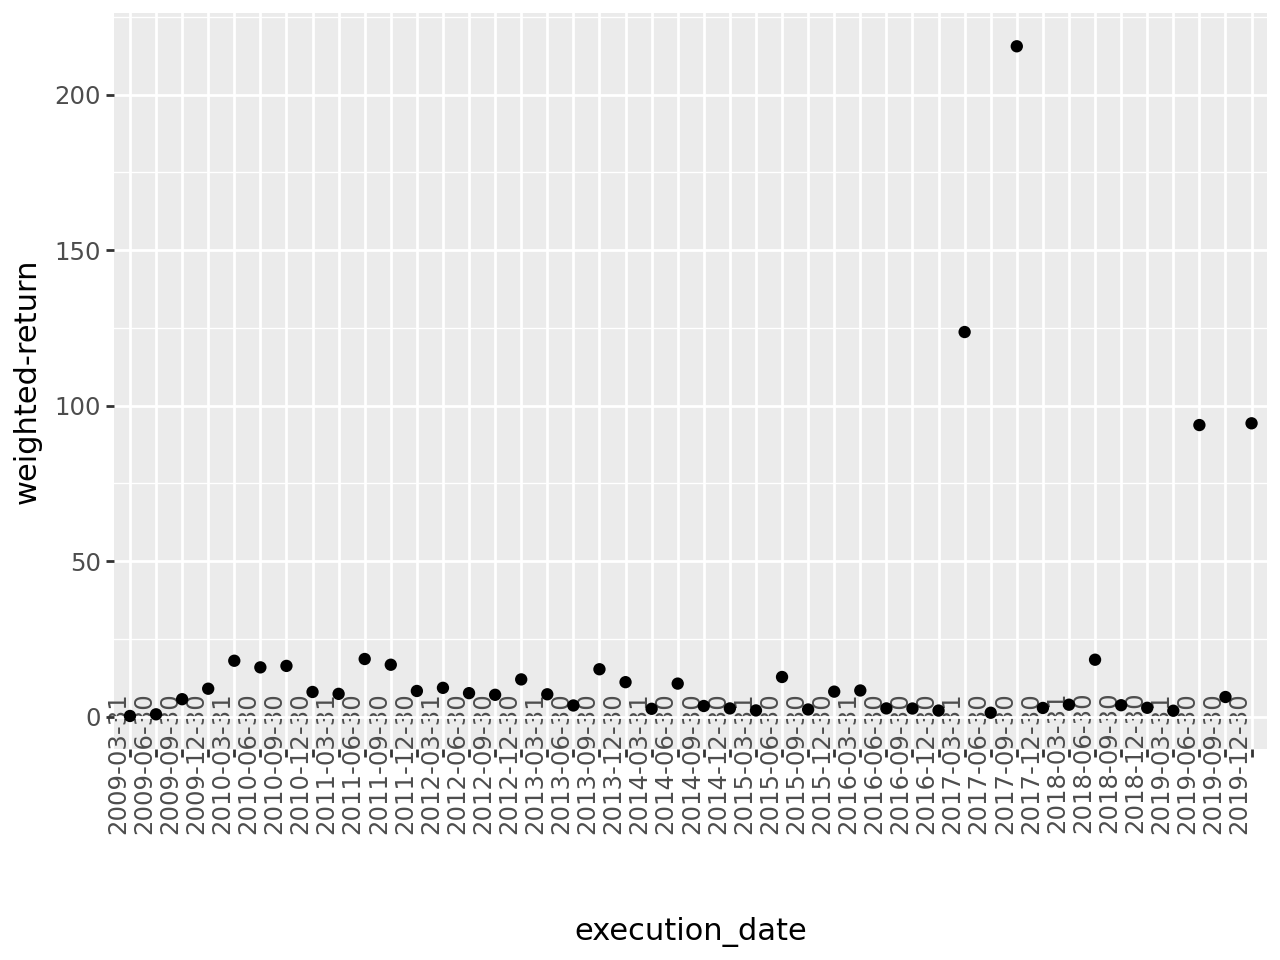

In [147]:
ggplot(train_results_final_tree_3) + geom_point(aes(x = "execution_date", y = "weighted-return")) + theme(axis_text_x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [170]:
#with 50 best features
print_stats(test_results_2)
print("-------------------------------")
print_stats(train_results_2)

Mean Log Loss: 0.7562062501889308
Mean Weighted Return: 9.632302973890356
Mean of Top 10 Weighted Return: 124.14343315168647
-------------------------------
Mean Log Loss: 0.348983966511571
Mean Weighted Return: 13.654067274902596
Mean of Top 10 Weighted Return: 143.89111154938638


In [169]:
#with 15 best features
print_stats(test_results_3)
print("-------------------------------")
print_stats(train_results_3)

Mean Log Loss: 0.7599301640731985
Mean Weighted Return: 10.106810685559227
Mean of Top 10 Weighted Return: 124.14414650811102
-------------------------------
Mean Log Loss: 0.3820110361169327
Mean Weighted Return: 32.65777045894561
Mean of Top 10 Weighted Return: 421.3414169446173


we can se there are improvements in our model by taking into account less features ( the more important ones)

### SHAP

Lets check what happens if I do the same but using SHAP as my feature importance algorithm

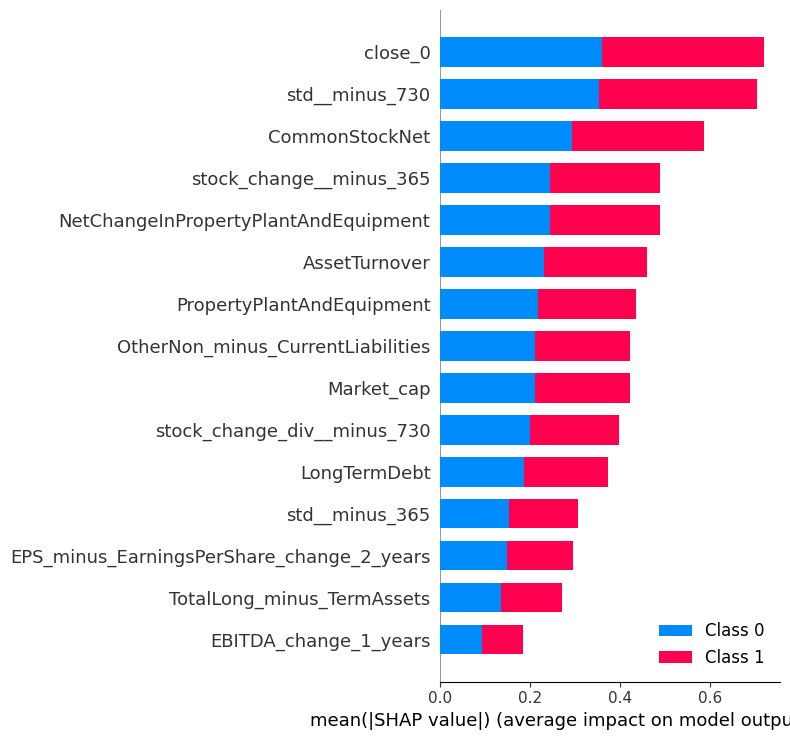

In [174]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")

In [186]:

shap_values = explainer.shap_values(X_train)
shap_values_2d = shap_values[1]


shap_values_df = pd.DataFrame(shap_values_2d, columns=X_train.columns)
mean_abs_shap_values = shap_values_df.abs().mean().sort_values(ascending=False)

SHAP_top_15_features = mean_abs_shap_values.head(15).index.tolist()
top_15_features_SHAP_df = pd.DataFrame(SHAP_top_15_features, columns=['feature'])

top_15_features_SHAP_df



,feature
0,close_0
1,std__minus_730
2,CommonStockNet
3,stock_change__minus_365
4,NetChangeInPropertyPlantAndEquipment
5,AssetTurnover
6,PropertyPlantAndEquipment
7,OtherNon_minus_CurrentLiabilities
8,Market_cap
9,stock_change_div__minus_730


In [187]:
df_cleaned_ft15_SHAP = filter_top_features(df_cleaned, top_15_features_SHAP_df)

all_results = {}
all_predicted_tickers_list = []
all_models = {}

execution_dates = np.sort( df_cleaned_ft15_SHAP['execution_date'].unique() )

for execution_date in execution_dates:
    print(execution_date)
    all_results,all_predicted_tickers_list,all_models,model,X_train,X_test = run_model_for_execution_date(df_cleaned_ft15_SHAP,execution_date,all_results,all_predicted_tickers_list,all_models,n_trees,False)
all_predicted_tickers = pd.concat(all_predicted_tickers_list)

test_results_4 = parse_results_into_df("valid_0")
train_results_4 = parse_results_into_df("training")
test_results_final_tree_4 = test_results_1.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")
train_results_final_tree_4 = train_results_1.sort_values(["execution_date","n_trees"]).drop_duplicates("execution_date",keep = "last")




2008-03-31T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-09-30T00:00:00.000000000
2008-12-30T00:00:00.000000000
2009-03-31T00:00:00.000000000
2009-06-30T00:00:00.000000000
2009-09-30T00:00:00.000000000
2009-12-30T00:00:00.000000000
2010-03-31T00:00:00.000000000
2010-06-30T00:00:00.000000000
2010-09-30T00:00:00.000000000
2010-12-30T00:00:00.000000000
2011-03-31T00:00:00.000000000
2011-06-30T00:00:00.000000000
2011-09-30T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-03-31T00:00:00.000000000
2012-06-30T00:00:00.000000000
2012-09-30T00:00:00.000000000
2012-12-30T00:00:00.000000000
2013-03-31T00:00:00.000000000
2013-06-30T00:00:00.000000000
2013-09-30T00:00:00.000000000
2013-12-30T00:00:00.000000000
2014-03-31T00:00:00.000000000
2014-06-30T00:00:00.000000000
2014-09-30T00:00:00.000000000
2014-12-30T00:00:00.000000000
2015-03-31T00:00:00.000000000
2015-06-30T00:00:00.000000000
2015-09-30T00:00:00.000000000
2015-12-30T00:00:00.000000000
2016-03-31T00:00:00.000000000
2016-06-30

In [188]:
#with 15 best features SHAP
print_stats(test_results_4)
print("-------------------------------")
print_stats(train_results_4)

Mean Log Loss: 0.7644946864347838
Mean Weighted Return: 10.10795998289586
Mean of Top 10 Weighted Return: 124.14414650811102
-------------------------------
Mean Log Loss: 0.38196770994530216
Mean Weighted Return: 31.8084845673848
Mean of Top 10 Weighted Return: 432.98374865716795


Kind off similar to the previous improvement make sense as most features are the same

## Conclusions 
 
I will leave it here for this PR althought theres more that could be done, here are some conclusions:
* getting a reduced data set taking only into account tickers with more data(less NaNs) led to better results
* reducing the number of features taking only the more important ones led to better results